### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import logging
import subprocess
import os
from datetime import datetime
from collections import Counter, OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingWarmRestarts
import torchvision
from torchvision import models
from apex import amp

from torch_lr_finder import LRFinder

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2, ToTensor

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import cv2
import skimage.io
import IPython.display as display
from PIL import Image

plt.ion()
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Local Imports

In [3]:
# Paths
from chestxray.config import (PROJ_PATH,
                              PANDA_PATH,
                              MODEL_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)
# Competition related config
from chestxray.config import CFG

# Misc
from chestxray.misc import seed_torch

# Datasets
from chestxray.datasets import get_transforms, TrainDataset, TilesTrainDataset, LazyTilesDataset, PatchTrainDataset, H5PatchDataset, SeqenceRandomSampler

# Viz
from chestxray.visualize import (show_from_ids, show_batch, imshow, 
                                 plot_classes_preds, reverse_show_img, 
                                 plot_confusion_matrix, text_classes_preds)

# Nets
from chestxray.nets import TinyV2ConvNet, freeze_botom, PatchModel, PatchEnetModel, PatchBiTModel, TilesModel, AttentionModel
from chestxray.model_utils import (trainable_params, cce_loss_at_init, 
                                   init_last_layer_bias)
# Losses
from chestxray.losses import LabelSmoothSoftmaxCEV1, TopkCrossEntropy, TopkBCEWithLogitsLoss

# Optim
from chestxray.optimizers import RAdam

# Schedulers
from chestxray.schedulers import CosineAnnealingWarmUpRestarts

# postproc
from chestxray.postprocess import OptimizedRounder

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='GeForce RTX 2070 SUPER', major=7, minor=5, total_memory=7979MB, multi_processor_count=40)


### Fix Random Seed

In [6]:
seed_torch()

In [7]:
# torch.backends.cudnn.benchmark = True

### Load Data

In [8]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [9]:
TRAIN_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10616 entries, 0 to 10615
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10616 non-null  object
 1   data_provider  10616 non-null  object
 2   isup_grade     10616 non-null  int64 
 3   gleason_score  10616 non-null  object
dtypes: int64(1), object(3)
memory usage: 331.9+ KB


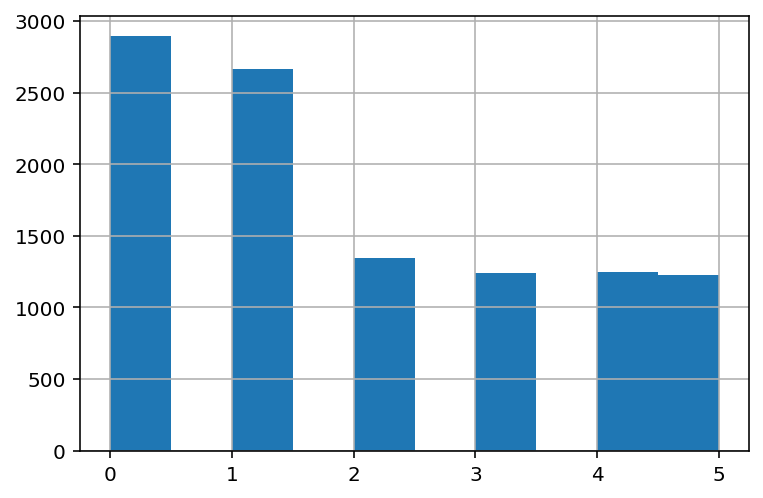

In [10]:
_ = TRAIN_DF[CFG.target_col].hist()

### Define Global Variables

In [11]:
if CFG.debug:
    EXP_NAME = "debug"
    writer = SummaryWriter(f"runs_v1/{EXP_NAME}")
    print(f"Start experiment: {EXP_NAME}")
else:
    if not CFG.resume:
        now = datetime.now()
        EXP_NAME = now.strftime("%d-%m-%Y-%H-%M")
        print(f"Start experiment: {EXP_NAME}")

        writer = SummaryWriter(f"runs_v1/{EXP_NAME}")
    else:
        # if resume should define from what to start
        PREV_NAME = CFG.prev_exp
        writer = SummaryWriter(f"runs_v1/{PREV_NAME}_{CFG.stage}")

Start experiment: 03-07-2020-08-40


In [12]:
# Set logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

log_format = logging.Formatter('%(message)s')
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(log_format)
logger.handlers = [stream_handler]
# add logging handler to save training to the file
log_fname = f"{PROJ_PATH/'logs'}/{EXP_NAME}.log"
file_handler = logging.FileHandler(log_fname, mode="a")
file_handler.setFormatter(log_format)
logger.handlers.append(file_handler)

In [13]:
LOSSES = {
    "cce" : nn.CrossEntropyLoss(),
    "ls_soft_ce" : LabelSmoothSoftmaxCEV1(),
    "ohem" : TopkCrossEntropy(),
    "bce" : TopkBCEWithLogitsLoss() if CFG.ohem else nn.BCEWithLogitsLoss(),
}

In [14]:
# key - string, value - tuple(sceduler, if it epoch type)
epoch_type = True
SCHEDULERS = {
    "reduce_on_plateau" : (ReduceLROnPlateau, epoch_type),
    "one_cycle": (OneCycleLR, not epoch_type),
    "cawr": (CosineAnnealingWarmUpRestarts, not epoch_type),
    "none": (None, None)
}

In [15]:
# schedulers
def get_scheduler(optimizer,train_dataloader, schedule_type=CFG.schedule_type, resume=False):
    assert schedule_type in SCHEDULERS, f"{schedule_type} not in SCHEDULERS"
    if schedule_type == "reduce_on_plateau":
        return (SCHEDULERS[schedule_type][0](optimizer, 'min', factor=0.5, patience=CFG.rlopp if not resume else CFG.rlopp + 2, verbose=True), 
                SCHEDULERS[schedule_type][1])
    elif schedule_type == "one_cycle":
        return (SCHEDULERS[schedule_type][0](optimizer, max_lr=[CFG.lr, CFG.lr*10] if CFG.finetune == "1stage" else CFG.lr,
                                             steps_per_epoch=int(len(train_dataloader) / CFG.accum_step), epochs=CFG.epoch, pct_start=1/CFG.epoch, 
                                             cycle_momentum=False, final_div_factor=CFG.oc_final_div_factor),
                SCHEDULERS[schedule_type][1])
    elif schedule_type == "cawr":
        return (SCHEDULERS[schedule_type][0](optimizer, T_0=CFG.cawr_T_0, T_mult=CFG.cawr_T_mult, eta_max=CFG.lr, T_up=CFG.cawr_T_up, gamma=CFG.cawr_gamma),
                SCHEDULERS[schedule_type][1])
    else:
        return (SCHEDULERS[schedule_type][0],
                SCHEDULERS[schedule_type][1])

### Train Eval Loop

In [16]:
# Train Eval Loop
def train_eval_loop(
    train_dataloader,
    val_dataloader,
    model,
    optimizer,
    criterion,
    accum_step=CFG.accum_step,
    checkpoint=False,
    num_epochs=CFG.epoch,
    device=device,
    tb_tag="",
    model_name="debug",
):
    """Split it into the set of inner functions to siplify the loop itself"""
    # Inner Functions
    # write to TensorBoard helpers
    def weights_to_tb(step=0):
        conv1_weight = list(model.parameters())[0].data.to("cpu")
        img_grid = torchvision.utils.make_grid(conv1_weight.float(), normalize=True)
        writer.add_image(
            tag=f"Model conv1 weights {tb_tag}", img_tensor=img_grid, global_step=step
        )

    def input_img_to_tb(inputs, step):
        img = reverse_show_img(inputs[0], denorm=True)
        writer.add_image(
            tag=f"Input Image {tb_tag}",
            img_tensor=img,
            global_step=step,
            dataformats="HWC",
        )
        del img

    def preds_to_tb(outputs, inputs, labels, step):
        figure = plot_classes_preds(
            outputs.to("cpu"), inputs.to("cpu"), labels.to("cpu")
        )
        writer.add_figure(
            tag=f"Actuals vs Predictions {tb_tag}", figure=figure, global_step=step
        )

    def text_preds_to_tb(outputs, labels, step):
        preds, targs = compute_preds(outputs, labels)
        preds_text = f"targs: {targs}, preds: {preds}"
        writer.add_text(
            f"Actuals vs Predictions {tb_tag}", preds_text, global_step=step
        )

    def metrics_to_tb(mode, train_loss, train_score, val_loss, val_score, step):
        writer.add_text(
            f"On best {mode} save:",
            f"tr_loss: {train_loss:.4f}, tr_qwk: {train_score:.4f}, val_loss: {val_loss:.4f}, val_qwk: {val_score:.4f}",  # noqa
            global_step=step,
        )

    def conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, step):
        writer.add_figure(
            tag=f"Confusion matrix {tb_tag}",
            figure=plot_confusion_matrix(
                val_epoch_labels, val_epoch_preds, normalize=True
            ),
            global_step=step,
        )
        
    def attention_to_tb(att, step):
        att_arr = att.data.cpu().numpy()[0, 0]
        text = f"{np.around(att_arr, decimals=3)}"
        writer.add_text(f"Attention Map for Oth Val sample {tb_tag}", text, global_step=step)
        
        
    def compute_preds(outputs, labels, loss_type=CFG.loss):
        if loss_type == "bce":
            preds = outputs.detach().sigmoid().sum(1).round()
            targs = labels.sum(1)
        else:
            preds = outputs.detach().argmax(1)
            targs = labels
        return preds.int(), targs.int()
        

    # Train/Eval Loop
    # write first layer weights to TB @ init phase
    if not CFG.debug:
        weights_to_tb()

    # prepare model and optimizer
    model.to(device)
    if CFG.use_amp:  # automatic mixed precision
        model, optimizer = amp.initialize(model, optimizer, opt_level="O2")
        
    # init scheduler after amp init of optimizer
    scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader, resume=CFG.resume)
    
    # define epochs numbers to look into input images and predictions,
    # no more than 30 times per full training
    vis_step = np.ceil(num_epochs / 30).astype(int)
    visual_epochs = list(range(0, num_epochs, vis_step))
    # metrics to wathch for model checkpointing
    best_qwk = -100 if not checkpoint else checkpoint["best_qwk"]
    best_val_loss = np.inf if not checkpoint else checkpoint["best_val_loss"]

    start_epoch = 0 if not checkpoint else checkpoint["epoch"] + 1
    for epoch in range(start_epoch, num_epochs):
        logging.info(f"Epoch {epoch}/{num_epochs - 1}")
        logging.info("=" * 10)

        # Training Phase
        # Set training mode
        model.train()
        train_running_loss = 0.0
        accum_train_loss = 0.0
        train_epoch_preds, train_epoch_labels = [], []

        # We accumulate, zero at training epoch begins
        optimizer.zero_grad()

        # Iterate over train data.
        tk_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in tk_train:
            # Calculate global step for TensorBoard
            train_global_step = epoch * len(train_dataloader) + i

            inputs, labels = data
            # Visualize input before model at the middle of epoch:
            if epoch in visual_epochs and i == len(train_dataloader) // 2:
                input_img_to_tb(inputs, train_global_step)

            inputs = inputs.to(device)
            labels = labels.to(device)

            if CFG.att:
                outputs, _ = model(inputs) # don't need att map here
            else:
                outputs = model(inputs)
            
            # then usimg accumulated gradients they sum up every loss.backward, we want mean of gradients
            # and so pararameter updates will be the same in case of accum_step > 1
            loss = criterion(outputs, labels) / accum_step
            if CFG.use_amp:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            
            accum_train_loss += loss.item()
            # we accumulate gradients and make optimization step once per
            # # of accum_step
            if (i + 1) % accum_step == 0:
                optimizer.step()
                optimizer.zero_grad()
                # Add Batch Type Scheduler step here (update lr only after optimizer step):
                if scheduler and not sch_is_epoch_type:
                    if CFG.schedule_type == "cawr":
                        scheduler.step(epoch + i / len(train_dataloader))
                    else:
                        scheduler.step()

                # loss is mean across batch, divide by number of steps in epoch
                # (so loss is normalized) + we only update train_running_loss every accum_step
                train_running_loss += accum_train_loss / (len(train_dataloader) / accum_step)
                # tensorboarding loss
                writer.add_scalar(
                    tag=f"Training loss {tb_tag}",
                    scalar_value=accum_train_loss,
                    global_step=train_global_step,
                )
                # zero accum_train_loss 
                accum_train_loss = 0.

            # collect train preds and labels for QWK
            preds, targs = compute_preds(outputs, labels)
            train_epoch_preds.append(preds)
            train_epoch_labels.append(targs)
            
        # Validation Phase
        # Set evaluation mode
        model.eval()
        val_running_loss = 0.0
        val_epoch_preds, val_epoch_labels = [], []
        # Iterate over val data
        tk_val = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for j, data in tk_val:
            # Calculate global step
            val_global_step = epoch * len(val_dataloader) + j
            inputs, labels = data
            if CFG.aux_tile:
                inp_main, inp_aux = inputs
                inp_main, inp_aux = inp_main.to(device), inp_aux.to(device)
            else:
                inputs = inputs.to(device)
            
            labels = labels.to(device)
            with torch.no_grad():
                if CFG.aux_tile:
                    out_main = model(inp_main)
                    out_aux = model(inp_aux)
                    outputs = (out_main + out_aux) / 2
                else:
                    if CFG.att:
                        outputs, att = model(inputs)
                    else:
                        outputs = model(inputs)
            if CFG.ohem:
                loss = criterion(outputs, labels, valid=True)
            else:
                loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() / len(val_dataloader)
            # tensorboarding loss
            writer.add_scalar(
                tag=f"Validation loss {tb_tag}",
                scalar_value=loss.item(),
                global_step=val_global_step,
            )

            # collect validation preds and labels for QWK
            preds, targs = compute_preds(outputs, labels)
            val_epoch_preds.append(preds)
            val_epoch_labels.append(targs)

            # visualise predictions for 0th validation batch
            if epoch in visual_epochs and j == 0:
                text_preds_to_tb(outputs, labels, val_global_step)
                
                # look into attention map if use it
                if CFG.att:
                    attention_to_tb(att, val_global_step)

        # Epoch type Schedulers
        if scheduler and sch_is_epoch_type:
            scheduler.step(val_running_loss)
        # Write lr to TBD
        if CFG.finetune == "1stage":
            writer.add_scalar(
                tag=f"lr Interim {tb_tag}:",
                scalar_value=optimizer.param_groups[0]["lr"],
                global_step=train_global_step,
            )
            writer.add_scalar(
                tag=f"lr Classifier {tb_tag}:",
                scalar_value=optimizer.param_groups[1]["lr"],
                global_step=train_global_step,
            )

        else:
            writer.add_scalar(
                tag=f"lr {tb_tag}:",
                scalar_value=optimizer.param_groups[0]["lr"],
                global_step=train_global_step,
            )

        # "End of Epoch" Phase
        logging.info(
            f"Training Loss: {train_running_loss:.4f}\tValidation Loss: {val_running_loss:.4f}"  # noqa
        )

        # Calculate epoch predictions distribution
        train_epoch_preds = torch.cat(train_epoch_preds).cpu().numpy()
        train_epoch_labels = torch.cat(train_epoch_labels).cpu().numpy()
        val_epoch_preds = torch.cat(val_epoch_preds).cpu().numpy()
        val_epoch_labels = torch.cat(val_epoch_labels).cpu().numpy()
        logging.info(
            f"Counter train preds: {Counter(train_epoch_preds)}\tCounter val preds: {Counter(val_epoch_preds)}"  # noqa
        )
        # Calculate epoch QWK
        train_qwk = cohen_kappa_score(
            train_epoch_preds, train_epoch_labels, weights="quadratic"
        )
        val_qwk = cohen_kappa_score(
            val_epoch_preds, val_epoch_labels, weights="quadratic"
        )
        logging.info(f"Epoch train QWK: {train_qwk:.3f}\tval QWK: {val_qwk:.3f}")
        writer.add_scalar(
            tag=f"Training QWK {tb_tag}", scalar_value=train_qwk, global_step=epoch
        )
        writer.add_scalar(
            tag=f"Validation QWK {tb_tag}", scalar_value=val_qwk, global_step=epoch
        )

        # On the best val loss do:
        if val_running_loss < best_val_loss:
            # update best and save model
            best_val_loss = val_running_loss
            logging.info(f"  Epoch {epoch} - Save Best Loss: {best_val_loss:.4f} Model")
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "best_val_loss": best_val_loss,
                    "best_qwk": val_qwk,
                },
                f"{MODEL_PATH}/{model_name}_{epoch}_loss.pth",
            )
            # add losses as text to TB
            metrics_to_tb(
                "loss",
                train_running_loss,
                train_qwk,
                val_running_loss,
                val_qwk,
                val_global_step,
            )
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
            
        # On the best val loss do:
        if val_qwk > best_qwk:
            # update best and save model
            best_qwk = val_qwk
            logging.info(f"  Epoch {epoch} - Save Best QWK: {best_qwk:.4f} Model")
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "best_val_loss": val_running_loss,
                    "best_qwk": best_qwk,
                },
                f"{MODEL_PATH}/{model_name}_{epoch}_qwk.pth",
            )
            # add losses as text to TB
            metrics_to_tb(
                "qwk",
                train_running_loss,
                train_qwk,
                val_running_loss,
                val_qwk,
                val_global_step,
            )
            # add image of conv1 weights to TB
            if not CFG.debug:
                weights_to_tb(val_global_step)
            # add confusion matrix to TB
            conf_matrix_to_tb(val_epoch_labels, val_epoch_preds, val_global_step)
        
        # maybe it helps!
#         torch.cuda.empty_cache()

    # End of loop
    return model, best_val_loss, best_qwk

### Prepare CV - strategy

In [17]:
CFG.debug = True

In [17]:
# That for the first time

In [28]:
if CFG.debug:
    folds_fn = "folds_db.csv"
    try: 
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.sample(n=500, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    folds_fn = "folds.csv"
    try:
        folds = pd.read_csv(PANDA_PATH/folds_fn)
    except FileNotFoundError:
        folds = TRAIN_DF.copy()

In [16]:
if not (PANDA_PATH/folds_fn).exists():
    train_labels = folds[CFG.target_col].values
    kf = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
    for fold, (train_index, val_index) in enumerate(kf.split(folds.values, train_labels)):
        folds.loc[val_index, 'fold'] = int(fold)
    folds['fold'] = folds['fold'].astype(int)
    folds.to_csv(PANDA_PATH/folds_fn, index=None)
    folds.head()

NameError: name 'folds_fn' is not defined

In [15]:
# Here use existing (folds_dedup is folds_cleaned + dropped duplicates)
# See corresponding notebooks: Suspicious_Input for cleaning
# and Find_Drop_Duplicates for duplicates

In [17]:
if CFG.debug:
    folds = pd.read_csv(PANDA_PATH/"folds_db.csv")
else:
    folds = pd.read_csv(PANDA_PATH/"folds_dedup.csv")

In [18]:
folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10061 entries, 0 to 10060
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image_id       10061 non-null  object
 1   data_provider  10061 non-null  object
 2   isup_grade     10061 non-null  int64 
 3   gleason_score  10061 non-null  object
 4   fold           10061 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 393.1+ KB


In [19]:
# folds = folds.sample(200)

### Init Data

In [20]:
# get folds (all experiments validated on fold 0)
train_df = folds[folds["fold"] != 0].copy()
val_df = folds[folds["fold"] == 0].copy()

# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False) # same allways to compare with previous results
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False, aux_tile=CFG.aux_tile)
    val_ds = TilesTrainDataset(val_df, is_train=False, transform=get_transforms(data="valid"), debug=False, aux_tile=CFG.aux_tile)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    val_ds = PatchTrainDataset(val_df, is_train=False, debug=False)
elif CFG.dataset == "hdf5":
    train_ds = H5PatchDataset(file_path=PANDA_PATH / "hdf5", fnames=["patch256x16x1_fold_1.h5", "patch256x16x1_fold_2.h5", "patch256x16x1_fold_3.h5"])
    val_ds = H5PatchDataset(file_path=PANDA_PATH / "hdf5", fnames=["patch256x16x1_fold_0.h5"])
else:
    print(f"No such dataset {CFG.dataset}")
    
# define a data loader
if CFG.dataset == "hdf5":
    # use specific sampler (so not to load hdf5 files to memory too frequently)
    sampler = SeqenceRandomSampler(len(train_ds), train_ds._common_len)
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, sampler=sampler, num_workers=min(CFG.batch_size, 8), pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size, 8), pin_memory=True)
else:
    train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size+2, 6), pin_memory=True)
    val_dataloader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=min(CFG.batch_size+2, 6), pin_memory=False)

### Init Functions

In [21]:
def init_model(train_df=train_df, arch=CFG.arch, pre_init_fc_bias=CFG.pre_init_fc_bias, pretrained=True):
    # For now only torchvision models ok for attention
    if CFG.att:
        assert arch in ["resnet50", "resnet34"]
    
    # MIL variant
    if CFG.dataset == "patch":
        if arch == "efnet":
            model_ft = PatchEnetModel(backbone=CFG.enet_bone, pretrained=pretrained)
        elif arch == "bitM":
            model_ft = PatchBiTModel(pretrained=pretrained)
        else:
            if CFG.att:
                model_ft = AttentionModel(arch=arch, pretrained=pretrained)
            else:
                model_ft = PatchModel(arch=arch, pretrained=pretrained)
            if pre_init_fc_bias:
                if CFG.loss in ["cce", "ls_soft_ce", "ohem"]:
                    # initialize bias in the model
                    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
                    model_ft = init_last_layer_bias(model_ft, cls_probas)
    # Stitched Tiles variant
    elif CFG.dataset == "tiles":
        if arch in ["resnet50", "resnet34"]:
            model_ft = TilesModel(arch=arch, pretrained=pretrained)
        else:
            print(f"Tiles model for {arch} is not yet implemented!")
    
    return model_ft


def init_optimizer(model_ft):
    if CFG.finetune == "1stage":
        freeze_botom(model_ft)
        interm_params = [
            p[1]
            for p in model_ft.named_parameters()
            if (not p[0].startswith("fc") and p[1].requires_grad)
        ]
        if CFG.optim == "adam":
            optimizer = torch.optim.Adam(
                [
                    {"params": interm_params, "lr": CFG.lr},
                    {"params": model_ft.fc.parameters(), "lr": CFG.lr * 10},
                ]
            )
        elif CFG.optim == "sgd":
            optimizer = torch.optim.SGD(
                [
                    {"params": interm_params, "lr": CFG.lr},
                    {"params": model_ft.fc.parameters(), "lr": CFG.lr * 10},
                ],
                momentum=0.9,
                nesterov=True,
            )
    else:
        LR = CFG.lr / 1000 if CFG.schedule_type == "cawr" else CFG.lr
        if CFG.optim == "adam":
            optimizer = torch.optim.Adam(
                model_ft.parameters(), lr=LR, amsgrad=False
            )
        elif CFG.optim == "adamw":
            optimizer = torch.optim.AdamW(model_ft.parameters(), lr=LR, 
                                          weight_decay=CFG.wd)
        elif CFG.optim == "sgd":
            optimizer = torch.optim.SGD(
                model_ft.parameters(), lr=LR, momentum=0.9, nesterov=True
            )
        elif CFG.optim == "radam":
            optimizer = RAdam(model_ft.parameters(), lr=LR)

    return optimizer

criterion = LOSSES[CFG.loss]

### Debug Runs

In [23]:
print(" ".join([f"{key}: {val}" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: True seed: 1982 img_height: 224 img_width: 224 target_size: 6 img_id_col: image_id target_col: isup_grade tiff_layer: 1 stoch_sample: True num_tiles: 36 tile_sz: 224 batch_size: 8 accum_step: 1 dataset: tiles aux_tile: False aux_tile_sz: 0 aux_tile_num: 0 aug_type: light att: False arch: resnet34 enet_bone: efficientnet-b0 finetune: False model_cls: one_layer pre_init_fc_bias: False ohem: True loss: bce optim: radam lr: 0.0003 wd: 0.01 schedule_type: cawr oc_final_div_factor: 10.0 cawr_T_0: 5 cawr_T_mult: 2 cawr_T_up: 1 cawr_gamma: 1.0 rlopp: 1 resume: False prev_exp: None from_epoch: 0 stage: 0 epoch: 50 n_fold: 4 use_amp: True descript: bce-ohem + rn34 + one cycle + 224x36 tiles + AdamW


In [24]:
logging.info(f'Start: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')
model_ft = init_model()
optimizer = init_optimizer(model_ft)
    
scheduler, sch_is_epoch_type = get_scheduler(optimizer, train_dataloader)

_ = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, num_epochs=35)
logging.info(f'Finish: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')

Start: 01-07-2020-19-52
Epoch 0/34


Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


  5%|▌         | 1/20 [00:04<01:19,  4.16s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


 10%|█         | 2/20 [00:04<00:55,  3.10s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
100%|██████████| 6/6 [00:03<00:00,  1.77it/s]
Training Loss: 1.2113	Validation Loss: 0.5695
Counter train preds: Counter({3: 97, 2: 36, 4: 21, 1: 1})	Counter val preds: Counter({2: 37, 3: 7, 1: 1})
Epoch train QWK: -0.022	val QWK: 0.125
  Epoch 0 - Save Best Loss: 0.5695 Model
  Epoch 0 - Save Best QWK: 0.1245 Model


Normalized confusion matrix
[[0.         0.         0.90909091 0.09090909 0.         0.        ]
 [0.         0.07692308 0.84615385 0.07692308 0.         0.        ]
 [0.         0.         0.81818182 0.18181818 0.         0.        ]
 [0.         0.         0.75       0.25       0.         0.        ]
 [0.         0.         0.8        0.2        0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]]


Epoch 1/34


Normalized confusion matrix
[[0.         0.         0.90909091 0.09090909 0.         0.        ]
 [0.         0.07692308 0.84615385 0.07692308 0.         0.        ]
 [0.         0.         0.81818182 0.18181818 0.         0.        ]
 [0.         0.         0.75       0.25       0.         0.        ]
 [0.         0.         0.8        0.2        0.         0.        ]
 [0.         0.         0.         1.         0.         0.        ]]


100%|██████████| 6/6 [00:03<00:00,  1.65it/s]
Training Loss: 0.7313	Validation Loss: 0.4664
Counter train preds: Counter({2: 88, 1: 46, 3: 21})	Counter val preds: Counter({2: 27, 1: 10, 3: 6, 0: 1, 4: 1})
Epoch train QWK: 0.153	val QWK: 0.386
  Epoch 1 - Save Best Loss: 0.4664 Model
  Epoch 1 - Save Best QWK: 0.3863 Model


Normalized confusion matrix
[[0.09090909 0.45454545 0.45454545 0.         0.         0.        ]
 [0.         0.23076923 0.53846154 0.23076923 0.         0.        ]
 [0.         0.18181818 0.72727273 0.09090909 0.         0.        ]
 [0.         0.         0.75       0.25       0.         0.        ]
 [0.         0.         0.8        0.2        0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]]


Epoch 2/34


Normalized confusion matrix
[[0.09090909 0.45454545 0.45454545 0.         0.         0.        ]
 [0.         0.23076923 0.53846154 0.23076923 0.         0.        ]
 [0.         0.18181818 0.72727273 0.09090909 0.         0.        ]
 [0.         0.         0.75       0.25       0.         0.        ]
 [0.         0.         0.8        0.2        0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]]


100%|██████████| 6/6 [00:03<00:00,  1.66it/s]
Training Loss: 0.6117	Validation Loss: 0.5048
Counter train preds: Counter({1: 62, 2: 61, 3: 30, 0: 2})	Counter val preds: Counter({3: 18, 2: 18, 1: 7, 0: 1, 4: 1})
Epoch train QWK: 0.409	val QWK: 0.385
Epoch 3/34
100%|██████████| 6/6 [00:03<00:00,  1.81it/s]
Training Loss: 0.5338	Validation Loss: 0.4780
Counter train preds: Counter({2: 62, 1: 47, 3: 40, 4: 5, 0: 1})	Counter val preds: Counter({2: 19, 3: 15, 1: 9, 0: 1, 4: 1})
Epoch train QWK: 0.517	val QWK: 0.338
Epoch 4/34
100%|██████████| 6/6 [00:03<00:00,  1.85it/s]
Training Loss: 0.5284	Validation Loss: 0.4770
Counter train preds: Counter({2: 61, 1: 54, 3: 34, 4: 5, 0: 1})	Counter val preds: Counter({2: 21, 3: 11, 1: 11, 0: 1, 4: 1})
Epoch train QWK: 0.536	val QWK: 0.400
  Epoch 4 - Save Best QWK: 0.4000 Model
Epoch 5/34


Normalized confusion matrix
[[0.09090909 0.54545455 0.27272727 0.09090909 0.         0.        ]
 [0.         0.23076923 0.46153846 0.30769231 0.         0.        ]
 [0.         0.18181818 0.63636364 0.18181818 0.         0.        ]
 [0.         0.         0.25       0.75       0.         0.        ]
 [0.         0.         0.8        0.2        0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]]


100%|██████████| 6/6 [00:03<00:00,  1.72it/s]
Training Loss: 0.5473	Validation Loss: 0.4791
Counter train preds: Counter({1: 65, 2: 54, 3: 29, 4: 6, 0: 1})	Counter val preds: Counter({2: 17, 3: 14, 1: 10, 4: 2, 0: 2})
Epoch train QWK: 0.549	val QWK: 0.489
  Epoch 5 - Save Best QWK: 0.4895 Model
Epoch 6/34


Normalized confusion matrix
[[0.09090909 0.54545455 0.36363636 0.         0.         0.        ]
 [0.         0.23076923 0.38461538 0.38461538 0.         0.        ]
 [0.09090909 0.09090909 0.45454545 0.36363636 0.         0.        ]
 [0.         0.         0.25       0.75       0.         0.        ]
 [0.         0.         0.4        0.4        0.2        0.        ]
 [0.         0.         0.         0.         1.         0.        ]]


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]
Training Loss: 0.4666	Validation Loss: 0.5216
Counter train preds: Counter({1: 67, 2: 42, 3: 29, 0: 9, 4: 8})	Counter val preds: Counter({3: 18, 2: 12, 1: 8, 4: 6, 0: 1})
Epoch train QWK: 0.631	val QWK: 0.338
Epoch 7/34
100%|██████████| 6/6 [00:03<00:00,  1.77it/s]
Training Loss: 0.4753	Validation Loss: 0.4521
Counter train preds: Counter({1: 60, 2: 46, 3: 29, 0: 9, 4: 9, 5: 2})	Counter val preds: Counter({2: 21, 1: 14, 3: 7, 4: 3})
Epoch train QWK: 0.647	val QWK: 0.354
  Epoch 7 - Save Best Loss: 0.4521 Model
Epoch 8/34


Normalized confusion matrix
[[0.         0.45454545 0.54545455 0.         0.         0.        ]
 [0.         0.30769231 0.46153846 0.15384615 0.07692308 0.        ]
 [0.         0.27272727 0.63636364 0.09090909 0.         0.        ]
 [0.         0.25       0.         0.75       0.         0.        ]
 [0.         0.2        0.4        0.2        0.2        0.        ]
 [0.         0.         0.         0.         1.         0.        ]]


100%|██████████| 6/6 [00:03<00:00,  1.68it/s]
Training Loss: 0.3996	Validation Loss: 0.3822
Counter train preds: Counter({1: 63, 2: 47, 3: 23, 4: 12, 0: 7, 5: 3})	Counter val preds: Counter({2: 17, 1: 15, 3: 10, 0: 2, 4: 1})
Epoch train QWK: 0.719	val QWK: 0.547
  Epoch 8 - Save Best Loss: 0.3822 Model
  Epoch 8 - Save Best QWK: 0.5470 Model


Normalized confusion matrix
[[0.09090909 0.63636364 0.27272727 0.         0.         0.        ]
 [0.         0.46153846 0.46153846 0.07692308 0.         0.        ]
 [0.09090909 0.09090909 0.54545455 0.27272727 0.         0.        ]
 [0.         0.         0.25       0.75       0.         0.        ]
 [0.         0.2        0.2        0.6        0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]]


Epoch 9/34


Normalized confusion matrix
[[0.09090909 0.63636364 0.27272727 0.         0.         0.        ]
 [0.         0.46153846 0.46153846 0.07692308 0.         0.        ]
 [0.09090909 0.09090909 0.54545455 0.27272727 0.         0.        ]
 [0.         0.         0.25       0.75       0.         0.        ]
 [0.         0.2        0.2        0.6        0.         0.        ]
 [0.         0.         0.         0.         1.         0.        ]]


100%|██████████| 6/6 [00:03<00:00,  1.52it/s]
Training Loss: 0.3443	Validation Loss: 0.4135
Counter train preds: Counter({1: 61, 2: 42, 3: 21, 4: 16, 0: 13, 5: 2})	Counter val preds: Counter({2: 13, 1: 12, 3: 10, 0: 6, 4: 4})
Epoch train QWK: 0.766	val QWK: 0.538
Epoch 10/34
100%|██████████| 6/6 [00:03<00:00,  1.65it/s]
Training Loss: 0.3211	Validation Loss: 0.3954
Counter train preds: Counter({1: 65, 3: 28, 2: 26, 0: 20, 4: 13, 5: 3})	Counter val preds: Counter({1: 17, 2: 16, 3: 10, 0: 1, 5: 1})
Epoch train QWK: 0.815	val QWK: 0.553
  Epoch 10 - Save Best QWK: 0.5527 Model
Epoch 11/34


Normalized confusion matrix
[[0.09090909 0.63636364 0.27272727 0.         0.         0.        ]
 [0.         0.38461538 0.46153846 0.15384615 0.         0.        ]
 [0.         0.36363636 0.45454545 0.18181818 0.         0.        ]
 [0.         0.         0.25       0.75       0.         0.        ]
 [0.         0.2        0.2        0.6        0.         0.        ]
 [0.         0.         0.         0.         0.         1.        ]]


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]
Training Loss: 0.3685	Validation Loss: 0.3964
Counter train preds: Counter({1: 56, 2: 36, 0: 22, 3: 22, 4: 15, 5: 4})	Counter val preds: Counter({1: 21, 2: 13, 3: 6, 4: 3, 0: 2})
Epoch train QWK: 0.786	val QWK: 0.597
  Epoch 11 - Save Best QWK: 0.5972 Model
Epoch 12/34


Normalized confusion matrix
[[0.09090909 0.72727273 0.18181818 0.         0.         0.        ]
 [0.         0.69230769 0.15384615 0.15384615 0.         0.        ]
 [0.09090909 0.27272727 0.54545455 0.09090909 0.         0.        ]
 [0.         0.         0.5        0.5        0.         0.        ]
 [0.         0.2        0.2        0.2        0.4        0.        ]
 [0.         0.         0.         0.         1.         0.        ]]


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]
Training Loss: 0.2705	Validation Loss: 0.4307
Counter train preds: Counter({1: 67, 2: 30, 3: 20, 4: 17, 0: 17, 5: 4})	Counter val preds: Counter({2: 14, 1: 12, 3: 11, 4: 6, 0: 1, 5: 1})
Epoch train QWK: 0.843	val QWK: 0.499
Epoch 13/34
100%|██████████| 6/6 [00:03<00:00,  1.85it/s]
Training Loss: 0.2346	Validation Loss: 0.3987
Counter train preds: Counter({1: 60, 2: 32, 3: 21, 4: 21, 0: 19, 5: 2})	Counter val preds: Counter({1: 16, 2: 13, 3: 9, 4: 5, 0: 1, 5: 1})
Epoch train QWK: 0.879	val QWK: 0.563
Epoch 14/34
100%|██████████| 6/6 [00:03<00:00,  1.72it/s]
Training Loss: 0.2177	Validation Loss: 0.4026
Counter train preds: Counter({1: 64, 2: 25, 0: 22, 4: 20, 3: 18, 5: 6})	Counter val preds: Counter({1: 16, 2: 12, 3: 11, 4: 4, 0: 1, 5: 1})
Epoch train QWK: 0.899	val QWK: 0.584
Epoch 15/34
100%|██████████| 6/6 [00:03<00:00,  1.84it/s]
Training Loss: 0.2526	Validation Loss: 0.4125
Counter train preds: Counter({1: 62, 2: 34, 0: 21, 3: 18, 4: 16

Normalized confusion matrix
[[0.54545455 0.36363636 0.09090909 0.         0.         0.        ]
 [0.07692308 0.69230769 0.23076923 0.         0.         0.        ]
 [0.         0.54545455 0.36363636 0.09090909 0.         0.        ]
 [0.         0.5        0.5        0.         0.         0.        ]
 [0.         0.2        0.2        0.4        0.2        0.        ]
 [0.         0.         0.         0.         0.         1.        ]]


100%|██████████| 6/6 [00:03<00:00,  1.79it/s]
Training Loss: 0.2328	Validation Loss: 0.5053
Counter train preds: Counter({1: 48, 0: 35, 2: 25, 3: 25, 4: 12, 5: 10})	Counter val preds: Counter({1: 13, 2: 12, 3: 8, 4: 7, 0: 3, 5: 2})
Epoch train QWK: 0.885	val QWK: 0.540
Epoch 22/34
100%|██████████| 6/6 [00:03<00:00,  1.71it/s]
Training Loss: 0.1490	Validation Loss: 0.4902
Counter train preds: Counter({1: 50, 0: 37, 2: 24, 3: 21, 4: 16, 5: 7})	Counter val preds: Counter({1: 18, 2: 11, 0: 9, 3: 4, 4: 3})
Epoch train QWK: 0.943	val QWK: 0.641
Epoch 23/34
100%|██████████| 6/6 [00:03<00:00,  1.64it/s]
Training Loss: 0.1521	Validation Loss: 0.4261
Counter train preds: Counter({1: 57, 0: 34, 2: 21, 3: 18, 5: 14, 4: 11})	Counter val preds: Counter({1: 15, 3: 10, 0: 9, 2: 8, 4: 3})
Epoch train QWK: 0.942	val QWK: 0.605
Epoch 24/34
100%|██████████| 6/6 [00:03<00:00,  1.72it/s]
Training Loss: 0.1211	Validation Loss: 0.5228
Counter train preds: Counter({1: 50, 0: 37, 2: 24, 3: 17, 4: 16, 5: 11})	Co

### Experiment Run

#### Learning Rate Finder

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic



Learning rate search finished. See the graph with {finder_name}.plot()


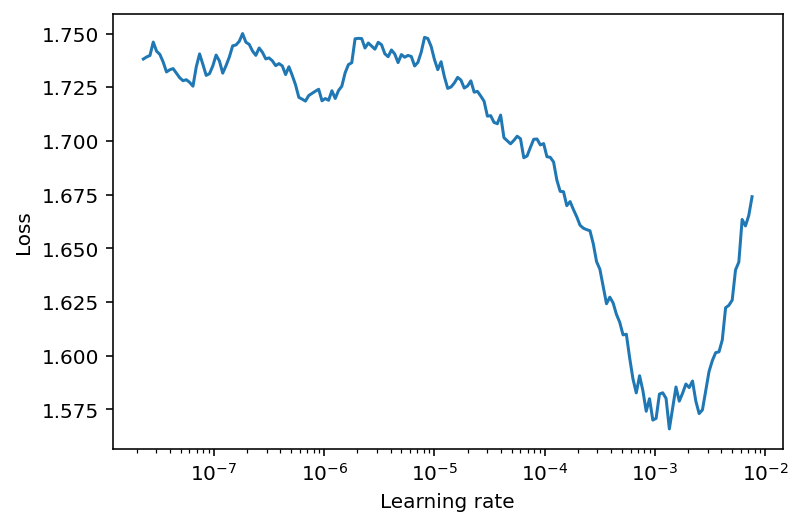

In [17]:
# get folds
train_df = folds[folds["fold"] != 0].copy()
# define datasets
if CFG.dataset == "lazy":
    train_ds = LazyTilesDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
elif CFG.dataset == "tiles":
    train_ds = TilesTrainDataset(train_df, is_train=CFG.stoch_sample, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
elif CFG.dataset == "patch":
    train_ds = PatchTrainDataset(train_df, transform=get_transforms(data="train", aug=CFG.aug_type), debug=False)
    
# define a data loader
train_dataloader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=min(CFG.batch_size, 10), pin_memory=True)

model_ft = Model(arch="resnet34")
# initialize bias in the model
cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
model_ft = init_last_layer_bias(model_ft, cls_probas)
model_ft.to(device)

criterion = LOSSES[CFG.loss]


if CFG.finetune == "1stage":
    freeze_botom(model_ft)
    interm_params = [p[1] for p in model_ft.named_parameters() if (not p[0].startswith('fc') and p[1].requires_grad)]
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
                ])
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD([
                    {'params': interm_params, 'lr': CFG.lr},
                    {'params': model_ft.fc.parameters(), 'lr': CFG.lr*10}
            ], momentum=0.9, nesterov=True)
else:
    if CFG.optim == "adam":
        optimizer = torch.optim.Adam(model_ft.parameters(), lr=CFG.lr * 1e-4, amsgrad=False)
    elif CFG.optim == "sgd":
        optimizer = torch.optim.SGD(model_ft.parameters(), lr=CFG.lr * 1e-4, momentum=0.9, nesterov=True)
    elif CFG.optim == "radam":
        optimizer = RAdam(model_ft.parameters(), lr=CFG.lr * 1e-4)
    
if CFG.use_amp:
    model_ft, optimizer = amp.initialize(model_ft, optimizer, opt_level='O1')
    
lr_finder = LRFinder(model_ft, optimizer, criterion, device=device)
lr_finder.range_test(train_dataloader, end_lr=1e-2, num_iter=200, step_mode="exp", accumulation_steps=CFG.accum_step)
lr_finder.plot()
lr_finder.reset()

#### Experiment

In [22]:
print(" ".join([f"{key}: {val}\n" for key, val in CFG.__dict__.items() if not key.startswith("__")]))

debug: False
 seed: 1982
 img_height: 224
 img_width: 224
 target_size: 6
 img_id_col: image_id
 target_col: isup_grade
 tiff_layer: 1
 stoch_sample: True
 num_tiles: 36
 tile_sz: 224
 batch_size: 8
 accum_step: 1
 dataset: patch
 aux_tile: False
 aux_tile_sz: 0
 aux_tile_num: 0
 aug_type: heavy
 att: True
 arch: resnet34
 enet_bone: efficientnet-b0
 finetune: False
 model_cls: one_layer
 pre_init_fc_bias: False
 ohem: True
 loss: bce
 optim: radam
 lr: 0.0003
 wd: 0.01
 schedule_type: cawr
 oc_final_div_factor: 10.0
 cawr_T_0: 10
 cawr_T_mult: 2
 cawr_T_up: 3
 cawr_gamma: 0.8
 rlopp: 1
 resume: False
 prev_exp: None
 from_epoch: 0
 stage: 0
 epoch: 70
 n_fold: 4
 use_amp: True
 descript: bce-ohem + rn34 + 224x36 patch-att + CAWUR



In [23]:
writer.add_text("Experiment Description:", CFG.descript)

In [24]:
model_ft = init_model()
optimizer = init_optimizer(model_ft)

In [25]:
logging.info(f'Start: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')
# Start Train/Eval Experiment
model_ft, best_loss, best_qwk = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, model_name=EXP_NAME)
logging.info(f'Finish: {datetime.now().strftime("%d-%m-%Y-%H-%M")}')

Start: 03-07-2020-08-41
Epoch 0/69


Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


  0%|          | 1/943 [00:04<1:04:06,  4.08s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
100%|██████████| 316/316 [02:26<00:00,  2.16it/s]
Training Loss: 0.5967	Validation Loss: 0.4569
Counter train preds: Counter({2: 2574, 3: 2280, 1: 2043, 4: 542, 0: 59, 5: 42})	Counter val preds: Counter({2: 838, 3: 489, 4: 468, 1: 379, 5: 347})
Epoch train QWK: 0.442	val QWK: 0.585
  Epoch 0 - Save Best Loss: 0.4569 Model
  Epoch 0 - Save Best QWK: 0.5854 Model


Normalized confusion matrix
[[0.         0.3988764  0.38764045 0.16011236 0.0491573  0.00421348]
 [0.         0.13479624 0.59717868 0.21943574 0.04702194 0.0015674 ]
 [0.         0.01269841 0.32698413 0.38412698 0.25396825 0.02222222]
 [0.         0.00689655 0.14137931 0.17586207 0.46206897 0.2137931 ]
 [0.         0.01030928 0.0790378  0.16151203 0.3814433  0.36769759]
 [0.         0.         0.05090909 0.05818182 0.28363636 0.60727273]]


Epoch 1/69


Normalized confusion matrix
[[0.         0.3988764  0.38764045 0.16011236 0.0491573  0.00421348]
 [0.         0.13479624 0.59717868 0.21943574 0.04702194 0.0015674 ]
 [0.         0.01269841 0.32698413 0.38412698 0.25396825 0.02222222]
 [0.         0.00689655 0.14137931 0.17586207 0.46206897 0.2137931 ]
 [0.         0.01030928 0.0790378  0.16151203 0.3814433  0.36769759]
 [0.         0.         0.05090909 0.05818182 0.28363636 0.60727273]]


100%|██████████| 316/316 [02:21<00:00,  2.23it/s]
Training Loss: 0.4660	Validation Loss: 0.3775
Counter train preds: Counter({1: 3036, 2: 2054, 3: 1140, 4: 989, 0: 227, 5: 94})	Counter val preds: Counter({1: 878, 2: 532, 4: 349, 5: 344, 3: 304, 0: 114})
Epoch train QWK: 0.651	val QWK: 0.702
  Epoch 1 - Save Best Loss: 0.3775 Model
  Epoch 1 - Save Best QWK: 0.7024 Model


Normalized confusion matrix
[[0.13342697 0.73735955 0.1011236  0.02106742 0.00702247 0.        ]
 [0.02507837 0.39498433 0.4200627  0.13479624 0.02507837 0.        ]
 [0.00634921 0.11111111 0.30793651 0.28888889 0.24761905 0.03809524]
 [0.00344828 0.06206897 0.13103448 0.15517241 0.37586207 0.27241379]
 [0.         0.08934708 0.12371134 0.1443299  0.3024055  0.34020619]
 [0.         0.08       0.07636364 0.09090909 0.19272727 0.56      ]]


Epoch 2/69


Normalized confusion matrix
[[0.13342697 0.73735955 0.1011236  0.02106742 0.00702247 0.        ]
 [0.02507837 0.39498433 0.4200627  0.13479624 0.02507837 0.        ]
 [0.00634921 0.11111111 0.30793651 0.28888889 0.24761905 0.03809524]
 [0.00344828 0.06206897 0.13103448 0.15517241 0.37586207 0.27241379]
 [0.         0.08934708 0.12371134 0.1443299  0.3024055  0.34020619]
 [0.         0.08       0.07636364 0.09090909 0.19272727 0.56      ]]


 15%|█▌        | 143/943 [01:18<06:51,  1.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


100%|██████████| 316/316 [02:21<00:00,  2.23it/s]
Training Loss: 0.4675	Validation Loss: 0.3249
Counter train preds: Counter({1: 2971, 2: 2072, 3: 1234, 4: 959, 0: 226, 5: 78})	Counter val preds: Counter({2: 907, 1: 749, 3: 434, 4: 309, 0: 106, 5: 16})
Epoch train QWK: 0.642	val QWK: 0.670
  Epoch 2 - Save Best Loss: 0.3249 Model
Epoch 3/69


Normalized confusion matrix
[[0.13202247 0.62921348 0.18679775 0.04353933 0.00702247 0.00140449]
 [0.01567398 0.35579937 0.58934169 0.03918495 0.         0.        ]
 [0.0031746  0.12380952 0.71111111 0.15555556 0.00634921 0.        ]
 [0.         0.04827586 0.3137931  0.49310345 0.14482759 0.        ]
 [0.00343643 0.04810997 0.18900344 0.35395189 0.39862543 0.00687285]
 [0.         0.02545455 0.10181818 0.30181818 0.52363636 0.04727273]]


 32%|███▏      | 301/943 [02:41<05:32,  1.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.4429	Validation Loss: 0.3190
Counter train preds: Counter({1: 3061, 2: 1975, 3: 1193, 4: 1018, 0: 225, 5: 68})	Counter val preds: Counter({1: 1223, 2: 645, 3: 274, 4: 236, 0: 136, 5: 7})
Epoch train QWK: 0.670	val QWK: 0.669
  Epoch 3 - Save Best Loss: 0.3190 Model
Epoch 4/69


Normalized confusion matrix
[[0.1741573  0.75561798 0.06601124 0.00280899 0.00140449 0.        ]
 [0.01253918 0.73040752 0.2460815  0.01097179 0.         0.        ]
 [0.00634921 0.36190476 0.59365079 0.03174603 0.00634921 0.        ]
 [0.         0.16206897 0.42758621 0.32758621 0.08275862 0.        ]
 [0.00687285 0.11340206 0.3161512  0.29209622 0.26116838 0.01030928]
 [0.         0.09090909 0.13818182 0.27272727 0.48363636 0.01454545]]


100%|██████████| 316/316 [02:21<00:00,  2.23it/s]
Training Loss: 0.4234	Validation Loss: 0.3233
Counter train preds: Counter({1: 3058, 2: 1882, 3: 1128, 4: 1062, 0: 308, 5: 102})	Counter val preds: Counter({1: 1260, 2: 719, 3: 315, 4: 190, 0: 32, 5: 5})
Epoch train QWK: 0.697	val QWK: 0.656
Epoch 5/69
 66%|██████▌   | 622/943 [05:29<02:44,  1.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.3971	Validation Loss: 0.2965
Counter train preds: Counter({1: 3023, 2: 1756, 4: 1123, 3: 1066, 0: 435, 5: 137})	Counter val preds: Counter({1: 715, 2: 493, 4: 400, 0: 312, 3: 307, 5: 294})
Epoch train QWK: 0.734	val QWK: 0.790
  Epoch 5 - Save Best Loss: 0.2965 Model
  Epoch 5 - Save Best QWK: 0.7897 Model


Normalized confusion matrix
[[0.40168539 0.48455056 0.06320225 0.03932584 0.00983146 0.00140449]
 [0.02821317 0.46238245 0.4169279  0.07680251 0.01567398 0.        ]
 [0.00952381 0.1047619  0.38730159 0.36507937 0.12063492 0.01269841]
 [0.01034483 0.06896552 0.12068966 0.19310345 0.48275862 0.12413793]
 [0.00343643 0.04467354 0.07560137 0.13402062 0.42268041 0.31958763]
 [0.00363636 0.03272727 0.01090909 0.07272727 0.29818182 0.58181818]]


Epoch 6/69


Normalized confusion matrix
[[0.40168539 0.48455056 0.06320225 0.03932584 0.00983146 0.00140449]
 [0.02821317 0.46238245 0.4169279  0.07680251 0.01567398 0.        ]
 [0.00952381 0.1047619  0.38730159 0.36507937 0.12063492 0.01269841]
 [0.01034483 0.06896552 0.12068966 0.19310345 0.48275862 0.12413793]
 [0.00343643 0.04467354 0.07560137 0.13402062 0.42268041 0.31958763]
 [0.00363636 0.03272727 0.01090909 0.07272727 0.29818182 0.58181818]]


100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.3700	Validation Loss: 0.2630
Counter train preds: Counter({1: 2907, 2: 1641, 4: 1184, 3: 970, 0: 663, 5: 175})	Counter val preds: Counter({1: 992, 2: 570, 4: 340, 0: 271, 3: 249, 5: 99})
Epoch train QWK: 0.764	val QWK: 0.789
  Epoch 6 - Save Best Loss: 0.2630 Model
Epoch 7/69


Normalized confusion matrix
[[0.34831461 0.56601124 0.07865169 0.00421348 0.00280899 0.        ]
 [0.02507837 0.68652038 0.26959248 0.01880878 0.         0.        ]
 [0.01269841 0.28888889 0.57142857 0.10793651 0.01904762 0.        ]
 [0.00344828 0.10689655 0.27586207 0.38275862 0.22758621 0.00344828]
 [0.00343643 0.0652921  0.18900344 0.21305842 0.47766323 0.05154639]
 [0.00363636 0.03636364 0.09818182 0.09818182 0.46181818 0.30181818]]


 79%|███████▉  | 743/943 [06:33<01:42,  1.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 316/316 [02:22<00:00,  2.21it/s]
Training Loss: 0.3394	Validation Loss: 0.2411
Counter train preds: Counter({1: 2750, 2: 1466, 4: 1210, 0: 941, 3: 932, 5: 241})	Counter val preds: Counter({1: 725, 2: 513, 0: 474, 4: 414, 3: 286, 5: 109})
Epoch train QWK: 0.809	val QWK: 0.828
  Epoch 7 - Save Best Loss: 0.2411 Model
  Epoch 7 - Save Best QWK: 0.8282 Model


Normalized confusion matrix
[[0.61095506 0.35814607 0.0252809  0.00140449 0.00421348 0.        ]
 [0.04231975 0.56269592 0.36833856 0.02507837 0.0015674  0.        ]
 [0.00952381 0.16190476 0.58095238 0.21904762 0.02857143 0.        ]
 [0.01724138 0.09310345 0.13103448 0.39655172 0.35172414 0.01034483]
 [0.00343643 0.0652921  0.08591065 0.20274914 0.58075601 0.06185567]
 [0.01090909 0.05090909 0.05090909 0.09454545 0.47272727 0.32      ]]


Epoch 8/69


Normalized confusion matrix
[[0.61095506 0.35814607 0.0252809  0.00140449 0.00421348 0.        ]
 [0.04231975 0.56269592 0.36833856 0.02507837 0.0015674  0.        ]
 [0.00952381 0.16190476 0.58095238 0.21904762 0.02857143 0.        ]
 [0.01724138 0.09310345 0.13103448 0.39655172 0.35172414 0.01034483]
 [0.00343643 0.0652921  0.08591065 0.20274914 0.58075601 0.06185567]
 [0.01090909 0.05090909 0.05090909 0.09454545 0.47272727 0.32      ]]


100%|██████████| 316/316 [02:22<00:00,  2.21it/s]
Training Loss: 0.3125	Validation Loss: 0.2327
Counter train preds: Counter({1: 2551, 2: 1362, 4: 1272, 0: 1198, 3: 893, 5: 264})	Counter val preds: Counter({1: 824, 2: 471, 0: 444, 4: 409, 3: 265, 5: 108})
Epoch train QWK: 0.840	val QWK: 0.842
  Epoch 8 - Save Best Loss: 0.2327 Model
  Epoch 8 - Save Best QWK: 0.8416 Model


Normalized confusion matrix
[[0.58426966 0.38061798 0.02949438 0.00280899 0.00280899 0.        ]
 [0.03291536 0.67241379 0.27429467 0.01880878 0.0015674  0.        ]
 [0.00952381 0.2031746  0.59047619 0.17460317 0.02222222 0.        ]
 [0.01034483 0.1        0.17586207 0.38965517 0.31724138 0.00689655]
 [0.00343643 0.05841924 0.09278351 0.19587629 0.58419244 0.0652921 ]
 [0.         0.05090909 0.04       0.09454545 0.49818182 0.31636364]]


Epoch 9/69


Normalized confusion matrix
[[0.58426966 0.38061798 0.02949438 0.00280899 0.00280899 0.        ]
 [0.03291536 0.67241379 0.27429467 0.01880878 0.0015674  0.        ]
 [0.00952381 0.2031746  0.59047619 0.17460317 0.02222222 0.        ]
 [0.01034483 0.1        0.17586207 0.38965517 0.31724138 0.00689655]
 [0.00343643 0.05841924 0.09278351 0.19587629 0.58419244 0.0652921 ]
 [0.         0.05090909 0.04       0.09454545 0.49818182 0.31636364]]


 91%|█████████ | 858/943 [07:32<00:44,  1.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


100%|██████████| 316/316 [02:22<00:00,  2.21it/s]
Training Loss: 0.2987	Validation Loss: 0.2291
Counter train preds: Counter({1: 2452, 2: 1356, 0: 1307, 4: 1282, 3: 852, 5: 291})	Counter val preds: Counter({1: 817, 0: 486, 2: 432, 4: 411, 3: 252, 5: 123})
Epoch train QWK: 0.851	val QWK: 0.848
  Epoch 9 - Save Best Loss: 0.2291 Model


Normalized confusion matrix
[[0.625      0.34129213 0.02808989 0.00280899 0.00280899 0.        ]
 [0.05172414 0.68965517 0.23824451 0.01880878 0.0015674  0.        ]
 [0.00634921 0.24126984 0.56190476 0.16825397 0.02222222 0.        ]
 [0.01034483 0.10344828 0.15172414 0.37931034 0.34827586 0.00689655]
 [0.00343643 0.05841924 0.08934708 0.18213058 0.58075601 0.08591065]
 [0.00727273 0.04       0.04727273 0.08       0.47636364 0.34909091]]


  Epoch 9 - Save Best QWK: 0.8476 Model
Epoch 10/69


Normalized confusion matrix
[[0.625      0.34129213 0.02808989 0.00280899 0.00280899 0.        ]
 [0.05172414 0.68965517 0.23824451 0.01880878 0.0015674  0.        ]
 [0.00634921 0.24126984 0.56190476 0.16825397 0.02222222 0.        ]
 [0.01034483 0.10344828 0.15172414 0.37931034 0.34827586 0.00689655]
 [0.00343643 0.05841924 0.08934708 0.18213058 0.58075601 0.08591065]
 [0.00727273 0.04       0.04727273 0.08       0.47636364 0.34909091]]


100%|██████████| 316/316 [02:21<00:00,  2.23it/s]
Training Loss: 0.3054	Validation Loss: 0.2545
Counter train preds: Counter({1: 2460, 0: 1337, 2: 1300, 4: 1255, 3: 891, 5: 297})	Counter val preds: Counter({1: 932, 2: 563, 4: 397, 0: 325, 3: 266, 5: 38})
Epoch train QWK: 0.849	val QWK: 0.805
Epoch 11/69
100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.3352	Validation Loss: 0.2427
Counter train preds: Counter({1: 2536, 2: 1493, 4: 1260, 0: 1142, 3: 864, 5: 245})	Counter val preds: Counter({1: 1037, 2: 419, 4: 400, 0: 278, 3: 273, 5: 114})
Epoch train QWK: 0.818	val QWK: 0.818
Epoch 12/69
  5%|▌         | 51/943 [00:30<07:40,  1.94it/s] 

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


 95%|█████████▌| 897/943 [07:53<00:23,  1.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.3595	Validation Loss: 0.2557
Counter train preds: Counter({1: 2579, 2: 1552, 4: 1162, 0: 1040, 3: 989, 5: 218})	Counter val preds: Counter({1: 700, 0: 659, 4: 379, 2: 374, 3: 230, 5: 179})
Epoch train QWK: 0.795	val QWK: 0.836
Epoch 13/69
100%|██████████| 316/316 [02:21<00:00,  2.23it/s]
Training Loss: 0.3653	Validation Loss: 0.2988
Counter train preds: Counter({1: 2709, 2: 1503, 4: 1222, 3: 976, 0: 942, 5: 188})	Counter val preds: Counter({1: 556, 2: 513, 4: 478, 0: 431, 3: 317, 5: 226})
Epoch train QWK: 0.786	val QWK: 0.794
Epoch 14/69
100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.3559	Validation Loss: 0.2724
Counter train preds: Counter({1: 2702, 2: 1551, 4: 1177, 3: 948, 0: 938, 5: 224})	Counter val preds: Counter({1: 875, 4: 486, 2: 378, 0: 346, 3: 250, 5: 186})
Epoch train QWK: 0.796	val QWK: 0.818
Epoch 15/69
 98%|█████████▊| 928/943 [08:09<00:07,  1.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 316/316 [02:21<00:00,  2.24it/s]
Training Loss: 0.3448	Validation Loss: 0.2463
Counter train preds: Counter({1: 2618, 2: 1484, 4: 1234, 0: 1067, 3: 898, 5: 239})	Counter val preds: Counter({1: 709, 2: 512, 0: 469, 4: 381, 3: 274, 5: 176})
Epoch train QWK: 0.809	val QWK: 0.836
Epoch 16/69
100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.3427	Validation Loss: 0.2938
Counter train preds: Counter({1: 2627, 2: 1463, 4: 1230, 0: 1060, 3: 928, 5: 232})	Counter val preds: Counter({1: 1149, 2: 496, 4: 336, 3: 314, 0: 188, 5: 38})
Epoch train QWK: 0.810	val QWK: 0.752
Epoch 17/69
100%|██████████| 316/316 [02:21<00:00,  2.23it/s]
Training Loss: 0.3334	Validation Loss: 0.2383
Counter train preds: Counter({1: 2624, 2: 1388, 4: 1239, 0: 1133, 3: 898, 5: 258})	Counter val preds: Counter({1: 766, 2: 448, 4: 442, 0: 427, 3: 297, 5: 141})
Epoch train QWK: 0.822	val QWK: 0.838
Epoch 18/69
 23%|██▎       | 214/943 [01:55<06:11,  1.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.3161	Validation Loss: 0.2504
Counter train preds: Counter({1: 2472, 2: 1376, 0: 1290, 4: 1241, 3: 863, 5: 298})	Counter val preds: Counter({1: 934, 2: 445, 0: 442, 4: 337, 3: 268, 5: 95})
Epoch train QWK: 0.841	val QWK: 0.822
Epoch 19/69
100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.3110	Validation Loss: 0.2281
Counter train preds: Counter({1: 2385, 0: 1381, 2: 1342, 4: 1298, 3: 852, 5: 282})	Counter val preds: Counter({1: 797, 0: 597, 4: 375, 2: 357, 3: 260, 5: 135})
Epoch train QWK: 0.848	val QWK: 0.850
  Epoch 19 - Save Best Loss: 0.2281 Model
  Epoch 19 - Save Best QWK: 0.8496 Model


Normalized confusion matrix
[[0.76544944 0.20786517 0.01825843 0.00702247 0.00140449 0.        ]
 [0.05956113 0.76802508 0.15360502 0.01724138 0.0015674  0.        ]
 [0.00952381 0.3015873  0.4984127  0.17142857 0.01269841 0.00634921]
 [0.02068966 0.10344828 0.15517241 0.39310345 0.31034483 0.01724138]
 [0.01030928 0.07216495 0.09965636 0.17869416 0.54295533 0.09621993]
 [0.00727273 0.04727273 0.05454545 0.08727273 0.44       0.36363636]]


Epoch 20/69


Normalized confusion matrix
[[0.76544944 0.20786517 0.01825843 0.00702247 0.00140449 0.        ]
 [0.05956113 0.76802508 0.15360502 0.01724138 0.0015674  0.        ]
 [0.00952381 0.3015873  0.4984127  0.17142857 0.01269841 0.00634921]
 [0.02068966 0.10344828 0.15517241 0.39310345 0.31034483 0.01724138]
 [0.01030928 0.07216495 0.09965636 0.17869416 0.54295533 0.09621993]
 [0.00727273 0.04727273 0.05454545 0.08727273 0.44       0.36363636]]


 76%|███████▌  | 715/943 [06:17<01:57,  1.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 316/316 [02:21<00:00,  2.23it/s]
Training Loss: 0.3018	Validation Loss: 0.2460
Counter train preds: Counter({1: 2329, 0: 1461, 2: 1321, 4: 1255, 3: 846, 5: 328})	Counter val preds: Counter({1: 932, 2: 428, 4: 418, 0: 330, 3: 298, 5: 115})
Epoch train QWK: 0.855	val QWK: 0.820
Epoch 21/69
100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.2833	Validation Loss: 0.2439
Counter train preds: Counter({1: 2271, 0: 1599, 4: 1291, 2: 1240, 3: 794, 5: 345})	Counter val preds: Counter({1: 829, 0: 678, 4: 362, 2: 319, 3: 285, 5: 48})
Epoch train QWK: 0.871	val QWK: 0.820
Epoch 22/69
100%|██████████| 316/316 [02:21<00:00,  2.23it/s]
Training Loss: 0.2741	Validation Loss: 0.2174
Counter train preds: Counter({1: 2228, 0: 1685, 4: 1286, 2: 1137, 3: 849, 5: 355})	Counter val preds: Counter({1: 885, 0: 526, 2: 344, 4: 334, 3: 250, 5: 182})
Epoch train QWK: 0.882	val QWK: 0.864
  Epoch 22 - Save Best Loss: 0.2174 Model
  Epoch 22 - Save Best QWK: 0.8641 Model


Normalized confusion matrix
[[0.69522472 0.28089888 0.01544944 0.00561798 0.00280899 0.        ]
 [0.03291536 0.82445141 0.12225705 0.01724138 0.0031348  0.        ]
 [0.00634921 0.32698413 0.51746032 0.12380952 0.02222222 0.0031746 ]
 [0.01034483 0.1        0.2        0.41034483 0.25172414 0.02758621]
 [0.00687285 0.06185567 0.08591065 0.18900344 0.53264605 0.12371134]
 [0.01090909 0.03272727 0.03272727 0.08       0.34545455 0.49818182]]


Epoch 23/69


Normalized confusion matrix
[[0.69522472 0.28089888 0.01544944 0.00561798 0.00280899 0.        ]
 [0.03291536 0.82445141 0.12225705 0.01724138 0.0031348  0.        ]
 [0.00634921 0.32698413 0.51746032 0.12380952 0.02222222 0.0031746 ]
 [0.01034483 0.1        0.2        0.41034483 0.25172414 0.02758621]
 [0.00687285 0.06185567 0.08591065 0.18900344 0.53264605 0.12371134]
 [0.01090909 0.03272727 0.03272727 0.08       0.34545455 0.49818182]]


 12%|█▏        | 112/943 [01:02<07:08,  1.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 316/316 [02:22<00:00,  2.21it/s]
Training Loss: 0.2614	Validation Loss: 0.2210
Counter train preds: Counter({1: 2208, 0: 1724, 4: 1261, 2: 1138, 3: 802, 5: 407})	Counter val preds: Counter({1: 753, 0: 550, 2: 423, 4: 389, 3: 311, 5: 95})
Epoch train QWK: 0.891	val QWK: 0.854
Epoch 24/69
100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.2454	Validation Loss: 0.2168
Counter train preds: Counter({1: 2104, 0: 1863, 4: 1269, 2: 1061, 3: 816, 5: 427})	Counter val preds: Counter({1: 765, 0: 609, 4: 383, 2: 323, 3: 268, 5: 173})
Epoch train QWK: 0.906	val QWK: 0.862
  Epoch 24 - Save Best Loss: 0.2168 Model
Epoch 25/69


Normalized confusion matrix
[[0.77247191 0.19241573 0.01966292 0.00983146 0.00561798 0.        ]
 [0.06112853 0.76959248 0.14263323 0.02194357 0.00470219 0.        ]
 [0.01269841 0.28571429 0.49206349 0.17777778 0.02857143 0.0031746 ]
 [0.03448276 0.07931034 0.12758621 0.38965517 0.34137931 0.02758621]
 [0.0137457  0.04810997 0.07216495 0.18213058 0.5532646  0.13058419]
 [0.00727273 0.03636364 0.01818182 0.09090909 0.38909091 0.45818182]]


 49%|████▉     | 465/943 [04:06<04:05,  1.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.2324	Validation Loss: 0.2160
Counter train preds: Counter({1: 2064, 0: 1907, 4: 1267, 2: 1068, 3: 783, 5: 451})	Counter val preds: Counter({1: 700, 0: 635, 2: 374, 4: 364, 3: 305, 5: 143})
Epoch train QWK: 0.914	val QWK: 0.864
  Epoch 25 - Save Best Loss: 0.2160 Model
Epoch 26/69


Normalized confusion matrix
[[0.81039326 0.15870787 0.01966292 0.00842697 0.00280899 0.        ]
 [0.05799373 0.73824451 0.18025078 0.01880878 0.00470219 0.        ]
 [0.01269841 0.23809524 0.54603175 0.17460317 0.02539683 0.0031746 ]
 [0.03448276 0.06206897 0.15517241 0.47931034 0.25172414 0.01724138]
 [0.0137457  0.04467354 0.07216495 0.2233677  0.56357388 0.08247423]
 [0.01090909 0.03636364 0.02545455 0.10181818 0.41454545 0.41090909]]


100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.2238	Validation Loss: 0.2178
Counter train preds: Counter({1: 2050, 0: 1966, 4: 1238, 2: 1030, 3: 781, 5: 475})	Counter val preds: Counter({1: 720, 0: 669, 4: 374, 2: 340, 3: 275, 5: 143})
Epoch train QWK: 0.919	val QWK: 0.866
  Epoch 26 - Save Best QWK: 0.8661 Model
Epoch 27/69


Normalized confusion matrix
[[0.84550562 0.12921348 0.01825843 0.00561798 0.00140449 0.        ]
 [0.05799373 0.78526646 0.13009404 0.02194357 0.00470219 0.        ]
 [0.01587302 0.27936508 0.53333333 0.14920635 0.01904762 0.0031746 ]
 [0.04482759 0.06206897 0.17241379 0.44482759 0.26551724 0.01034483]
 [0.02405498 0.04467354 0.06185567 0.19243986 0.59793814 0.0790378 ]
 [0.01818182 0.02909091 0.02909091 0.09090909 0.41090909 0.42181818]]


100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.2200	Validation Loss: 0.2158
Counter train preds: Counter({1: 2048, 0: 1971, 4: 1249, 2: 1018, 3: 769, 5: 485})	Counter val preds: Counter({1: 743, 0: 612, 4: 392, 2: 337, 3: 286, 5: 151})
Epoch train QWK: 0.921	val QWK: 0.869
  Epoch 27 - Save Best Loss: 0.2158 Model
  Epoch 27 - Save Best QWK: 0.8687 Model


Normalized confusion matrix
[[0.78932584 0.17696629 0.0238764  0.00561798 0.00421348 0.        ]
 [0.05015674 0.76959248 0.14263323 0.03134796 0.00626959 0.        ]
 [0.01269841 0.26349206 0.51746032 0.18095238 0.02222222 0.0031746 ]
 [0.03103448 0.07241379 0.14482759 0.43448276 0.30344828 0.0137931 ]
 [0.01030928 0.04467354 0.05841924 0.19931271 0.59450172 0.09278351]
 [0.00727273 0.03272727 0.02545455 0.07636364 0.42545455 0.43272727]]


Epoch 28/69


Normalized confusion matrix
[[0.78932584 0.17696629 0.0238764  0.00561798 0.00421348 0.        ]
 [0.05015674 0.76959248 0.14263323 0.03134796 0.00626959 0.        ]
 [0.01269841 0.26349206 0.51746032 0.18095238 0.02222222 0.0031746 ]
 [0.03103448 0.07241379 0.14482759 0.43448276 0.30344828 0.0137931 ]
 [0.01030928 0.04467354 0.05841924 0.19931271 0.59450172 0.09278351]
 [0.00727273 0.03272727 0.02545455 0.07636364 0.42545455 0.43272727]]


 11%|█         | 100/943 [00:56<07:17,  1.93it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 316/316 [02:22<00:00,  2.21it/s]
Training Loss: 0.2161	Validation Loss: 0.2150
Counter train preds: Counter({1: 2047, 0: 1972, 4: 1273, 2: 1008, 3: 767, 5: 473})	Counter val preds: Counter({1: 747, 0: 618, 4: 374, 2: 346, 3: 278, 5: 158})
Epoch train QWK: 0.923	val QWK: 0.867
  Epoch 28 - Save Best Loss: 0.2150 Model


Normalized confusion matrix
[[0.79634831 0.1741573  0.02106742 0.00702247 0.00140449 0.        ]
 [0.04858934 0.77429467 0.14420063 0.02821317 0.00470219 0.        ]
 [0.00952381 0.27301587 0.53333333 0.15555556 0.02222222 0.00634921]
 [0.03448276 0.06896552 0.15517241 0.43448276 0.28965517 0.01724138]
 [0.0137457  0.04810997 0.0652921  0.19243986 0.58075601 0.09965636]
 [0.01090909 0.03272727 0.02545455 0.08727273 0.4        0.44363636]]


Epoch 29/69
100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.2147	Validation Loss: 0.2158
Counter train preds: Counter({1: 2041, 0: 1989, 4: 1259, 2: 1011, 3: 757, 5: 483})	Counter val preds: Counter({1: 723, 0: 626, 4: 385, 2: 351, 3: 271, 5: 165})
Epoch train QWK: 0.927	val QWK: 0.869
  Epoch 29 - Save Best QWK: 0.8691 Model
Epoch 30/69


Normalized confusion matrix
[[0.80758427 0.16292135 0.02106742 0.00702247 0.00140449 0.        ]
 [0.04702194 0.76332288 0.15830721 0.02664577 0.00470219 0.        ]
 [0.00952381 0.25396825 0.53333333 0.18095238 0.01587302 0.00634921]
 [0.03448276 0.06206897 0.14137931 0.40689655 0.33793103 0.01724138]
 [0.01718213 0.04467354 0.06185567 0.18213058 0.58419244 0.10996564]
 [0.01090909 0.03272727 0.02909091 0.07636364 0.39272727 0.45818182]]


 51%|█████     | 478/943 [04:13<04:05,  1.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.2239	Validation Loss: 0.2226
Counter train preds: Counter({1: 2063, 0: 1962, 4: 1217, 2: 1010, 3: 791, 5: 497})	Counter val preds: Counter({1: 631, 0: 617, 4: 406, 2: 398, 3: 278, 5: 191})
Epoch train QWK: 0.919	val QWK: 0.861
Epoch 31/69
100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.2438	Validation Loss: 0.2552
Counter train preds: Counter({1: 2040, 0: 1897, 4: 1251, 2: 1121, 3: 762, 5: 469})	Counter val preds: Counter({1: 775, 0: 747, 2: 350, 4: 284, 5: 187, 3: 178})
Epoch train QWK: 0.907	val QWK: 0.836
Epoch 32/69
 85%|████████▌ | 806/943 [07:05<01:11,  1.92it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.2654	Validation Loss: 0.2428
Counter train preds: Counter({1: 2117, 0: 1803, 4: 1226, 2: 1134, 3: 833, 5: 427})	Counter val preds: Counter({1: 704, 0: 645, 4: 471, 2: 338, 3: 273, 5: 90})
Epoch train QWK: 0.892	val QWK: 0.839
Epoch 33/69
100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.2753	Validation Loss: 0.2493
Counter train preds: Counter({1: 2175, 0: 1746, 4: 1301, 2: 1151, 3: 785, 5: 382})	Counter val preds: Counter({0: 839, 1: 663, 4: 329, 2: 301, 3: 221, 5: 168})
Epoch train QWK: 0.884	val QWK: 0.841
Epoch 34/69
 98%|█████████▊| 922/943 [08:07<00:10,  1.96it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.2807	Validation Loss: 0.2250
Counter train preds: Counter({1: 2199, 0: 1676, 4: 1251, 2: 1217, 3: 817, 5: 380})	Counter val preds: Counter({0: 691, 1: 602, 4: 415, 2: 393, 3: 285, 5: 135})
Epoch train QWK: 0.877	val QWK: 0.856
Epoch 35/69
100%|██████████| 316/316 [02:22<00:00,  2.23it/s]
Training Loss: 0.2756	Validation Loss: 0.2403
Counter train preds: Counter({1: 2143, 0: 1741, 4: 1257, 2: 1199, 3: 821, 5: 379})	Counter val preds: Counter({0: 679, 1: 661, 4: 378, 2: 305, 5: 259, 3: 239})
Epoch train QWK: 0.883	val QWK: 0.854
Epoch 36/69
100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.2774	Validation Loss: 0.2346
Counter train preds: Counter({1: 2155, 0: 1721, 4: 1234, 2: 1202, 3: 833, 5: 395})	Counter val preds: Counter({1: 915, 0: 462, 2: 395, 4: 388, 3: 272, 5: 89})
Epoch train QWK: 0.882	val QWK: 0.840
Epoch 37/69
 11%|█▏        | 107/943 [00:59<07:11,  1.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.2696	Validation Loss: 0.2407
Counter train preds: Counter({1: 2102, 0: 1770, 4: 1257, 2: 1192, 3: 825, 5: 394})	Counter val preds: Counter({1: 701, 0: 608, 4: 454, 2: 317, 5: 222, 3: 219})
Epoch train QWK: 0.888	val QWK: 0.850
Epoch 38/69
100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.2659	Validation Loss: 0.2336
Counter train preds: Counter({1: 2098, 0: 1792, 4: 1247, 2: 1177, 3: 811, 5: 415})	Counter val preds: Counter({1: 707, 0: 520, 4: 433, 2: 392, 3: 283, 5: 186})
Epoch train QWK: 0.893	val QWK: 0.846
Epoch 39/69
 29%|██▉       | 274/943 [02:27<05:44,  1.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 316/316 [02:21<00:00,  2.23it/s]
Training Loss: 0.2643	Validation Loss: 0.2681
Counter train preds: Counter({1: 2132, 0: 1775, 4: 1218, 2: 1163, 3: 826, 5: 426})	Counter val preds: Counter({0: 840, 1: 793, 2: 272, 4: 257, 3: 202, 5: 157})
Epoch train QWK: 0.893	val QWK: 0.812
Epoch 40/69
100%|██████████| 316/316 [02:22<00:00,  2.21it/s]
Training Loss: 0.2551	Validation Loss: 0.2405
Counter train preds: Counter({1: 2099, 0: 1825, 4: 1195, 2: 1149, 3: 826, 5: 446})	Counter val preds: Counter({1: 791, 0: 715, 4: 337, 2: 306, 3: 244, 5: 128})
Epoch train QWK: 0.899	val QWK: 0.843
Epoch 41/69
 49%|████▉     | 465/943 [04:07<04:06,  1.94it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 316/316 [02:21<00:00,  2.23it/s]
Training Loss: 0.2502	Validation Loss: 0.2445
Counter train preds: Counter({1: 2073, 0: 1875, 4: 1259, 2: 1105, 3: 792, 5: 436})	Counter val preds: Counter({1: 717, 0: 700, 2: 409, 4: 337, 3: 265, 5: 93})
Epoch train QWK: 0.902	val QWK: 0.837
Epoch 42/69
100%|██████████| 316/316 [02:21<00:00,  2.24it/s]
Training Loss: 0.2473	Validation Loss: 0.2329
Counter train preds: Counter({1: 2103, 0: 1874, 4: 1219, 2: 1075, 3: 816, 5: 453})	Counter val preds: Counter({1: 749, 0: 591, 2: 404, 4: 396, 3: 285, 5: 96})
Epoch train QWK: 0.905	val QWK: 0.846
Epoch 43/69
 64%|██████▎   | 599/943 [05:17<02:56,  1.95it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 316/316 [02:22<00:00,  2.21it/s]
Training Loss: 0.2430	Validation Loss: 0.2326
Counter train preds: Counter({1: 2083, 0: 1898, 4: 1247, 2: 1069, 3: 798, 5: 445})	Counter val preds: Counter({1: 670, 0: 645, 4: 440, 2: 354, 3: 276, 5: 136})
Epoch train QWK: 0.908	val QWK: 0.855
Epoch 44/69
100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.2322	Validation Loss: 0.2353
Counter train preds: Counter({1: 2032, 0: 1943, 4: 1216, 2: 1047, 3: 817, 5: 485})	Counter val preds: Counter({0: 737, 1: 616, 4: 454, 2: 351, 3: 272, 5: 91})
Epoch train QWK: 0.915	val QWK: 0.853
Epoch 45/69
 77%|███████▋  | 723/943 [06:23<01:56,  1.88it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 316/316 [02:22<00:00,  2.21it/s]
Training Loss: 0.2289	Validation Loss: 0.2356
Counter train preds: Counter({1: 2059, 0: 1946, 4: 1201, 2: 1024, 3: 807, 5: 503})	Counter val preds: Counter({1: 728, 0: 584, 4: 415, 2: 390, 3: 298, 5: 106})
Epoch train QWK: 0.917	val QWK: 0.851
Epoch 46/69
100%|██████████| 316/316 [02:22<00:00,  2.22it/s]
Training Loss: 0.2262	Validation Loss: 0.2231
Counter train preds: Counter({1: 2053, 0: 1955, 4: 1211, 2: 1034, 3: 805, 5: 482})	Counter val preds: Counter({1: 744, 0: 631, 4: 414, 2: 295, 3: 288, 5: 149})
Epoch train QWK: 0.918	val QWK: 0.858
Epoch 47/69
100%|██████████| 316/316 [02:32<00:00,  2.07it/s]
Training Loss: 0.2188	Validation Loss: 0.2353
Counter train preds: Counter({1: 2032, 0: 1999, 4: 1215, 2: 1002, 3: 771, 5: 521})	Counter val preds: Counter({0: 651, 1: 594, 4: 456, 2: 362, 3: 284, 5: 174})
Epoch train QWK: 0.924	val QWK: 0.859
Epoch 48/69
 33%|███▎      | 312/943 [02:58<05:31,  1.91it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 316/316 [02:32<00:00,  2.07it/s]
Training Loss: 0.2053	Validation Loss: 0.2288
Counter train preds: Counter({0: 2043, 1: 1990, 4: 1221, 2: 975, 3: 784, 5: 527})	Counter val preds: Counter({0: 745, 1: 638, 4: 435, 2: 270, 3: 263, 5: 170})
Epoch train QWK: 0.933	val QWK: 0.866
Epoch 49/69
 82%|████████▏ | 771/943 [07:24<01:42,  1.68it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 316/316 [02:29<00:00,  2.12it/s]
Training Loss: 0.2060	Validation Loss: 0.2263
Counter train preds: Counter({0: 2049, 1: 1986, 4: 1245, 2: 1001, 3: 747, 5: 512})	Counter val preds: Counter({1: 800, 0: 632, 4: 340, 2: 316, 3: 260, 5: 173})
Epoch train QWK: 0.930	val QWK: 0.856
Epoch 50/69
100%|██████████| 316/316 [02:27<00:00,  2.14it/s]
Training Loss: 0.1978	Validation Loss: 0.2401
Counter train preds: Counter({0: 2066, 1: 1970, 4: 1183, 2: 995, 3: 775, 5: 551})	Counter val preds: Counter({1: 771, 0: 607, 3: 361, 2: 359, 4: 292, 5: 131})
Epoch train QWK: 0.935	val QWK: 0.845
Epoch 51/69
100%|██████████| 316/316 [02:27<00:00,  2.14it/s]
Training Loss: 0.1866	Validation Loss: 0.2285
Counter train preds: Counter({0: 2070, 1: 1981, 4: 1181, 2: 979, 3: 746, 5: 583})	Counter val preds: Counter({0: 741, 1: 682, 4: 332, 2: 304, 3: 280, 5: 182})
Epoch train QWK: 0.941	val QWK: 0.865
Epoch 52/69
100%|██████████| 316/316 [02:30<00:00,  2.10it/s]
Training Loss: 0.1809	Validation L

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 316/316 [02:25<00:00,  2.17it/s]
Training Loss: 0.1711	Validation Loss: 0.2377
Counter train preds: Counter({0: 2107, 1: 1997, 4: 1119, 2: 904, 3: 785, 5: 628})	Counter val preds: Counter({1: 710, 0: 648, 4: 384, 2: 353, 3: 295, 5: 131})
Epoch train QWK: 0.949	val QWK: 0.864
Epoch 55/69
100%|██████████| 316/316 [02:25<00:00,  2.17it/s]
Training Loss: 0.1662	Validation Loss: 0.2440
Counter train preds: Counter({0: 2095, 1: 1998, 4: 1129, 2: 918, 3: 781, 5: 619})	Counter val preds: Counter({0: 748, 1: 639, 4: 365, 2: 317, 3: 280, 5: 172})
Epoch train QWK: 0.951	val QWK: 0.859
Epoch 56/69
 58%|█████▊    | 547/943 [04:52<03:29,  1.89it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 316/316 [02:24<00:00,  2.18it/s]
Training Loss: 0.1533	Validation Loss: 0.2349
Counter train preds: Counter({0: 2121, 1: 1987, 4: 1125, 2: 919, 3: 756, 5: 632})	Counter val preds: Counter({1: 692, 0: 682, 4: 393, 2: 318, 3: 293, 5: 143})
Epoch train QWK: 0.956	val QWK: 0.868
Epoch 57/69
 16%|█▌        | 49/316 [00:25<02:21,  1.89it/s]


KeyboardInterrupt: 

In [ ]:
# After finish collect hyperparams used, best metrics and write to TensorBoard
hparam_dict = {key:val for key, val in CFG.__dict__.items() if not key.startswith("__")}
metric_dict = {"hp/best_loss": best_loss, "hp/best_qwk": best_qwk}
writer.add_hparams(hparam_dict=hparam_dict, metric_dict=metric_dict)

# Get the current git commit hash to add it in Tensorboard, to know exp code version
label = subprocess.check_output(["git", "describe", "--always"]).strip()
writer.add_text("Git commit hash:", label.decode())

In [29]:
torch.save(
            {
                "model_state_dict": model_ft.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_val_loss": best_loss,
                "best_qwk": best_qwk,
            },
            f"{MODEL_PATH}/{EXP_NAME}_last_loss.pth",
            )

#### Resume Training

In [19]:
checkpoint = torch.load(f"{MODEL_PATH}/{PREV_NAME}_{CFG.from_epoch}_loss.pth")

model_ft = PatchModel(arch=CFG.arch)
model_ft.load_state_dict(checkpoint["model_state_dict"])
model_ft.to(device)

optimizer = init_optimizer(model_ft)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# set smaller lr here
for param_group in optimizer.param_groups:
    param_group["lr"] = CFG.lr

In [20]:
for param_group in optimizer.param_groups:
    print(param_group['lr'])

5e-06


In [21]:
# Start Train/Eval Experiment
model_ft, best_loss, best_qwk = train_eval_loop(train_dataloader, val_dataloader, model_ft, optimizer, criterion, checkpoint=checkpoint, model_name=PREV_NAME)

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Epoch 18/29


  0%|          | 2/1991 [00:02<47:59,  1.45s/it]  

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


  0%|          | 3/1991 [00:02<36:39,  1.11s/it]/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value)
  1%|          | 20/1991 [00:08<10:34,  3.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


100%|██████████| 664/664 [02:48<00:00,  3.93it/s]

Training Loss: 0.7912	Validation Loss: 1.0411
Counter train preds: Counter({0: 2369, 1: 2107, 2: 919, 5: 874, 4: 857, 3: 836})	Counter val preds: Counter({1: 801, 0: 785, 5: 329, 4: 296, 2: 236, 3: 207})
Epoch train QWK: 0.899	val QWK: 0.824
Epoch 19/29



  2%|▏         | 30/1991 [00:11<10:15,  3.19it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


 58%|█████▊    | 1158/1991 [06:40<04:27,  3.12it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:52<00:00,  3.85it/s]

Training Loss: 0.7860	Validation Loss: 1.0326
Counter train preds: Counter({0: 2348, 1: 2076, 2: 946, 5: 895, 4: 865, 3: 832})	Counter val preds: Counter({0: 810, 1: 757, 2: 311, 4: 276, 5: 261, 3: 239})
Epoch train QWK: 0.902	val QWK: 0.823
Epoch 20/29



 65%|██████▍   | 1286/1991 [07:04<03:43,  3.15it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:49<00:00,  3.91it/s]


Training Loss: 0.7739	Validation Loss: 1.0376
Counter train preds: Counter({0: 2346, 1: 2086, 2: 957, 5: 891, 4: 852, 3: 830})	Counter val preds: Counter({0: 789, 1: 754, 4: 336, 5: 296, 3: 240, 2: 239})
Epoch train QWK: 0.908	val QWK: 0.832
  Epoch 20 - Save Best QWK: 0.8318 Model
Normalized confusion matrix
[[0.9142462  0.07053942 0.00276625 0.00138313 0.00276625 0.00829876]
 [0.07507508 0.83333333 0.06306306 0.01651652 0.00900901 0.003003  ]
 [0.03283582 0.32238806 0.42686567 0.13134328 0.06268657 0.0238806 ]
 [0.09324759 0.05787781 0.11254019 0.45337621 0.17363344 0.10932476]
 [0.06389776 0.04792332 0.04792332 0.07348243 0.62939297 0.13738019]
 [0.05882353 0.02287582 0.00653595 0.06535948 0.18300654 0.66339869]]
Epoch 21/29


 78%|███████▊  | 1560/1991 [08:07<02:12,  3.26it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:46<00:00,  3.98it/s]

Training Loss: 0.7603	Validation Loss: 1.0409
Counter train preds: Counter({0: 2350, 1: 2056, 2: 916, 4: 881, 3: 881, 5: 878})	Counter val preds: Counter({1: 823, 0: 772, 4: 322, 5: 297, 2: 238, 3: 202})
Epoch train QWK: 0.913	val QWK: 0.827
Epoch 22/29



100%|██████████| 664/664 [02:51<00:00,  3.88it/s]


Training Loss: 0.7578	Validation Loss: 1.0242
Counter train preds: Counter({0: 2364, 1: 2060, 2: 930, 5: 881, 3: 875, 4: 852})	Counter val preds: Counter({0: 806, 1: 774, 3: 282, 2: 271, 4: 265, 5: 256})
Epoch train QWK: 0.905	val QWK: 0.819
  Epoch 22 - Save Best Loss: 1.0242 Model
Normalized confusion matrix
[[0.91839557 0.06777317 0.00276625 0.00276625 0.00276625 0.0055325 ]
 [0.08258258 0.84234234 0.05555556 0.01201201 0.003003   0.0045045 ]
 [0.03283582 0.34925373 0.48358209 0.10447761 0.01791045 0.0119403 ]
 [0.09967846 0.06430868 0.14790997 0.49839228 0.10289389 0.08681672]
 [0.08306709 0.06070288 0.0543131  0.15974441 0.5399361  0.10223642]
 [0.0620915  0.02614379 0.02287582 0.10457516 0.17647059 0.60784314]]
Epoch 23/29


 27%|██▋       | 532/1991 [02:55<07:40,  3.17it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:51<00:00,  3.87it/s]

Training Loss: 0.7567	Validation Loss: 1.0275
Counter train preds: Counter({0: 2333, 1: 2082, 2: 934, 5: 883, 3: 871, 4: 859})	Counter val preds: Counter({0: 810, 1: 695, 2: 351, 5: 290, 4: 287, 3: 221})
Epoch train QWK: 0.910	val QWK: 0.825
Epoch 24/29



100%|██████████| 664/664 [02:50<00:00,  3.90it/s]

Training Loss: 0.7417	Validation Loss: 1.0299
Counter train preds: Counter({0: 2346, 1: 2052, 2: 938, 5: 900, 3: 869, 4: 857})	Counter val preds: Counter({0: 802, 1: 775, 5: 302, 3: 301, 4: 272, 2: 202})
Epoch train QWK: 0.918	val QWK: 0.829
Epoch 25/29



 28%|██▊       | 552/1991 [02:54<07:19,  3.27it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


 72%|███████▏  | 1424/1991 [07:37<02:50,  3.33it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:47<00:00,  3.97it/s]

Training Loss: 0.7373	Validation Loss: 1.0288
Counter train preds: Counter({0: 2352, 1: 2050, 2: 920, 5: 899, 3: 876, 4: 865})	Counter val preds: Counter({0: 794, 1: 760, 5: 304, 3: 277, 2: 275, 4: 244})
Epoch train QWK: 0.914	val QWK: 0.827
Epoch 26/29



 75%|███████▍  | 1488/1991 [07:48<02:34,  3.26it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:53<00:00,  3.83it/s]

Training Loss: 0.7313	Validation Loss: 1.0301
Counter train preds: Counter({0: 2340, 1: 2038, 2: 941, 5: 896, 3: 889, 4: 858})	Counter val preds: Counter({0: 795, 1: 761, 4: 295, 5: 290, 3: 276, 2: 237})
Epoch train QWK: 0.919	val QWK: 0.828
Epoch 27/29



 82%|████████▏ | 1630/1991 [09:15<01:51,  3.25it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:48<00:00,  3.94it/s]

Training Loss: 0.7174	Validation Loss: 1.0293
Counter train preds: Counter({0: 2331, 1: 2038, 2: 968, 5: 887, 4: 876, 3: 862})	Counter val preds: Counter({0: 806, 1: 744, 4: 304, 5: 297, 2: 271, 3: 232})
Epoch train QWK: 0.928	val QWK: 0.830
Epoch 28/29



 93%|█████████▎| 1854/1991 [10:05<00:44,  3.11it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


100%|██████████| 664/664 [02:45<00:00,  4.01it/s]


Training Loss: 0.7082	Validation Loss: 1.0334
Counter train preds: Counter({0: 2310, 1: 2049, 2: 958, 5: 900, 4: 888, 3: 857})	Counter val preds: Counter({0: 777, 1: 752, 4: 342, 2: 287, 3: 255, 5: 241})
Epoch train QWK: 0.927	val QWK: 0.836
  Epoch 28 - Save Best QWK: 0.8358 Model
Normalized confusion matrix
[[0.90871369 0.07192254 0.00414938 0.00414938 0.0055325  0.0055325 ]
 [0.07657658 0.82432432 0.07207207 0.01951952 0.0045045  0.003003  ]
 [0.02686567 0.33432836 0.48955224 0.09850746 0.03880597 0.0119403 ]
 [0.08038585 0.06109325 0.15434084 0.45016077 0.17684887 0.07717042]
 [0.06070288 0.04472843 0.06070288 0.12140575 0.62619808 0.08626198]
 [0.05228758 0.01960784 0.01633987 0.09150327 0.23202614 0.58823529]]
Epoch 29/29


100%|██████████| 664/664 [02:57<00:00,  3.74it/s]

Training Loss: 0.6978	Validation Loss: 1.0287
Counter train preds: Counter({0: 2313, 1: 2049, 2: 946, 5: 895, 4: 891, 3: 868})	Counter val preds: Counter({0: 819, 1: 726, 5: 297, 2: 274, 3: 270, 4: 268})
Epoch train QWK: 0.932	val QWK: 0.829


In [ ]:
# After finish collect hyperparams used, best metrics and write to TensorBoard
hparam_dict = {key:val for key, val in CFG.__dict__.items() if not key.startswith("__")}
metric_dict = {"hp/best_loss": best_loss, "hp/best_qwk": best_qwk}
writer.add_hparams(hparam_dict=hparam_dict, metric_dict=metric_dict)

# Get the current git commit hash to add it in Tensorboard, to know exp code version
label = subprocess.check_output(["git", "describe", "--always"]).strip()
writer.add_text("Git commit hash:", label.decode())

### Train with CV

In [34]:
checkpoint = "test_fold_{}.pth"
for fold in range(CFG.n_fold):
    train_df = folds[folds["fold"] != fold].copy()
    val_df = folds[folds["fold"] == fold].copy()
    
    train_ds = TrainDataset(train_df, transform=get_transforms(data="train"), debug=False)
    val_ds = TrainDataset(val_df, transform=get_transforms(data="valid"), debug=False)
    
    model = TinyV2ConvNet(CFG.target_size)
    # initialize bias in the model
    cls_probas = (train_df[CFG.target_col].value_counts() / len(train_df)).values
    model = init_last_layer_bias(model, cls_probas)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)
    print(f"Train with CV, on fold {fold}")
    model = train_eval_loop(train_ds, val_ds, model, optimizer, criterion, tb_tag=fold)
    torch.save(model.state_dict(), MODEL_PATH/checkpoint.format(fold))

Train with CV, on fold 0
Epoch 0/9
----------


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

Training Loss: 1.7832	Validation Loss: 1.6735
Counter train preds: Counter({1: 50, 4: 11, 3: 8, 0: 6})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.193	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.82it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.13it/s]

Training Loss: 1.5393	Validation Loss: 1.6932
Counter train preds: Counter({1: 39, 0: 21, 3: 7, 4: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.236	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.61it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

Training Loss: 1.4436	Validation Loss: 1.7056
Counter train preds: Counter({1: 34, 0: 26, 3: 7, 5: 5, 4: 3})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.321	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.05it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

Training Loss: 1.4152	Validation Loss: 1.6723
Counter train preds: Counter({0: 33, 1: 31, 3: 5, 4: 5, 5: 1})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.282	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.74it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3904	Validation Loss: 1.6386
Counter train preds: Counter({1: 33, 0: 28, 4: 6, 3: 5, 5: 3})	Counter val preds: Counter({1: 15, 5: 3, 0: 3, 2: 2, 4: 1, 3: 1})
Epoch train QWK: 0.393	val QWK: 0.186
Epoch 5/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.53it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.79it/s]

Training Loss: 1.3730	Validation Loss: 1.6927
Counter train preds: Counter({0: 33, 1: 26, 5: 7, 3: 4, 4: 4, 2: 1})	Counter val preds: Counter({1: 13, 5: 6, 2: 4, 3: 1, 0: 1})
Epoch train QWK: 0.517	val QWK: 0.545
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.96it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.81it/s]

Training Loss: 1.3238	Validation Loss: 1.8837
Counter train preds: Counter({0: 30, 1: 29, 5: 6, 3: 6, 4: 4})	Counter val preds: Counter({1: 9, 5: 7, 2: 6, 3: 3})
Epoch train QWK: 0.438	val QWK: 0.329
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.85it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

Training Loss: 1.3055	Validation Loss: 2.0990
Counter train preds: Counter({1: 34, 0: 22, 5: 8, 3: 7, 4: 2, 2: 2})	Counter val preds: Counter({2: 12, 5: 5, 3: 5, 1: 2, 4: 1})
Epoch train QWK: 0.552	val QWK: 0.326
Epoch 8/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.66it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.87it/s]

Training Loss: 1.3063	Validation Loss: 2.0883
Counter train preds: Counter({1: 35, 0: 25, 4: 7, 3: 5, 5: 3})	Counter val preds: Counter({2: 13, 5: 5, 1: 3, 3: 2, 4: 1, 0: 1})
Epoch train QWK: 0.549	val QWK: 0.199
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.77it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.86it/s]

Training Loss: 1.3191	Validation Loss: 1.8377
Counter train preds: Counter({1: 37, 0: 24, 5: 7, 4: 3, 3: 3, 2: 1})	Counter val preds: Counter({1: 21, 3: 2, 2: 1, 5: 1})
Epoch train QWK: 0.435	val QWK: 0.305
Train with CV, on fold 1
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.80it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.7209	Validation Loss: 1.7380
Counter train preds: Counter({0: 59, 3: 15, 1: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.263	val QWK: 0.000
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.81it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.5459	Validation Loss: 1.7958
Counter train preds: Counter({0: 36, 1: 32, 3: 5, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.331	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.4606	Validation Loss: 1.9763
Counter train preds: Counter({1: 34, 0: 29, 4: 8, 3: 4})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

Training Loss: 1.4206	Validation Loss: 1.8872
Counter train preds: Counter({1: 32, 0: 24, 4: 8, 3: 6, 5: 3, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.441	val QWK: 0.000
Epoch 4/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.28it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4067	Validation Loss: 2.2129
Counter train preds: Counter({1: 36, 0: 25, 3: 10, 5: 2, 2: 1, 4: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.388	val QWK: 0.000
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

Training Loss: 1.3640	Validation Loss: 2.9000
Counter train preds: Counter({1: 33, 0: 24, 3: 12, 2: 4, 4: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.364	val QWK: 0.000
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.87it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

Training Loss: 1.3085	Validation Loss: 2.7819
Counter train preds: Counter({1: 33, 0: 20, 3: 11, 2: 4, 4: 4, 5: 3})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.568	val QWK: 0.000
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

Training Loss: 1.3142	Validation Loss: 2.3783
Counter train preds: Counter({1: 36, 0: 21, 3: 9, 2: 5, 5: 3, 4: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.435	val QWK: 0.116
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Training Loss: 1.2917	Validation Loss: 3.1009
Counter train preds: Counter({1: 38, 0: 19, 2: 6, 4: 5, 3: 4, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.433	val QWK: 0.009
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.24it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.2545	Validation Loss: 2.9466
Counter train preds: Counter({1: 32, 0: 20, 3: 10, 4: 5, 2: 5, 5: 3})	Counter val preds: Counter({0: 23, 2: 2})
Epoch train QWK: 0.635	val QWK: 0.009
Train with CV, on fold 2
Epoch 0/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

Training Loss: 1.6856	Validation Loss: 1.8174
Counter train preds: Counter({1: 48, 3: 15, 0: 12})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.208	val QWK: 0.000
Epoch 1/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.45it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.5455	Validation Loss: 2.4182
Counter train preds: Counter({1: 37, 0: 21, 3: 16, 2: 1})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.313	val QWK: 0.000
Epoch 2/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

Training Loss: 1.4741	Validation Loss: 2.2700
Counter train preds: Counter({1: 33, 0: 26, 3: 14, 2: 2})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.287	val QWK: 0.000
Epoch 3/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.64it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.4289	Validation Loss: 2.4097
Counter train preds: Counter({1: 35, 0: 28, 3: 7, 2: 5})	Counter val preds: Counter({0: 25})
Epoch train QWK: 0.247	val QWK: 0.000
Epoch 4/9
----------



 20%|██        | 1/5 [00:00<00:01,  2.55it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

Training Loss: 1.3615	Validation Loss: 2.0392
Counter train preds: Counter({1: 39, 0: 25, 3: 7, 2: 4})	Counter val preds: Counter({0: 24, 2: 1})
Epoch train QWK: 0.307	val QWK: 0.064
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.67it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

Training Loss: 1.4250	Validation Loss: 1.6867
Counter train preds: Counter({1: 41, 0: 26, 3: 8})	Counter val preds: Counter({0: 20, 2: 3, 1: 2})
Epoch train QWK: 0.266	val QWK: 0.214
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.91it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Training Loss: 1.3328	Validation Loss: 1.7360
Counter train preds: Counter({1: 34, 0: 24, 3: 12, 2: 4, 5: 1})	Counter val preds: Counter({0: 18, 1: 5, 2: 2})
Epoch train QWK: 0.365	val QWK: 0.130
Epoch 7/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.21it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Training Loss: 1.3236	Validation Loss: 1.8248
Counter train preds: Counter({1: 33, 0: 21, 2: 13, 3: 6, 5: 2})	Counter val preds: Counter({0: 17, 1: 5, 2: 3})
Epoch train QWK: 0.316	val QWK: 0.272
Epoch 8/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.99it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.63it/s]

Training Loss: 1.2498	Validation Loss: 2.4719
Counter train preds: Counter({1: 34, 0: 24, 2: 8, 3: 8, 5: 1})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.392	val QWK: 0.259
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  8.02it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Training Loss: 1.2657	Validation Loss: 2.4212
Counter train preds: Counter({1: 39, 0: 21, 2: 6, 3: 6, 5: 3})	Counter val preds: Counter({0: 22, 2: 3})
Epoch train QWK: 0.409	val QWK: 0.259
Train with CV, on fold 3
Epoch 0/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.76it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.7337	Validation Loss: 1.6500
Counter train preds: Counter({1: 49, 2: 14, 0: 6, 5: 3, 3: 3})	Counter val preds: Counter({1: 24, 0: 1})
Epoch train QWK: 0.123	val QWK: -0.030
Epoch 1/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.52it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

Training Loss: 1.5647	Validation Loss: 1.7000
Counter train preds: Counter({1: 40, 0: 18, 3: 12, 2: 5})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.232	val QWK: 0.000
Epoch 2/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.84it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.09it/s]

Training Loss: 1.4733	Validation Loss: 1.6935
Counter train preds: Counter({1: 33, 0: 27, 3: 13, 2: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.337	val QWK: 0.000
Epoch 3/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.67it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

Training Loss: 1.4141	Validation Loss: 1.6876
Counter train preds: Counter({0: 29, 1: 28, 3: 10, 2: 6, 5: 2})	Counter val preds: Counter({1: 25})
Epoch train QWK: 0.475	val QWK: 0.000
Epoch 4/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.46it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

Training Loss: 1.3655	Validation Loss: 1.6186
Counter train preds: Counter({1: 35, 0: 26, 3: 7, 5: 4, 2: 3})	Counter val preds: Counter({1: 21, 2: 3, 0: 1})
Epoch train QWK: 0.395	val QWK: 0.012
Epoch 5/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.61it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Training Loss: 1.3591	Validation Loss: 1.6763
Counter train preds: Counter({1: 32, 0: 23, 3: 11, 2: 8, 5: 1})	Counter val preds: Counter({2: 17, 0: 6, 1: 2})
Epoch train QWK: 0.413	val QWK: 0.313
Epoch 6/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.59it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

Training Loss: 1.3191	Validation Loss: 1.6529
Counter train preds: Counter({1: 34, 0: 26, 3: 5, 2: 4, 4: 4, 5: 2})	Counter val preds: Counter({1: 12, 2: 9, 5: 2, 0: 2})
Epoch train QWK: 0.424	val QWK: 0.269
Epoch 7/9
----------



100%|██████████| 5/5 [00:00<00:00,  7.96it/s]

Visualising input



100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

Training Loss: 1.3050	Validation Loss: 1.7019
Counter train preds: Counter({1: 36, 0: 21, 2: 6, 3: 5, 5: 4, 4: 3})	Counter val preds: Counter({2: 13, 5: 7, 4: 3, 0: 2})
Epoch train QWK: 0.454	val QWK: 0.364
Epoch 8/9
----------



 60%|██████    | 3/5 [00:00<00:00,  3.98it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Training Loss: 1.2645	Validation Loss: 1.7029
Counter train preds: Counter({1: 36, 0: 22, 5: 7, 2: 5, 3: 4, 4: 1})	Counter val preds: Counter({2: 10, 5: 5, 0: 5, 1: 4, 3: 1})
Epoch train QWK: 0.461	val QWK: 0.309
Epoch 9/9
----------



100%|██████████| 5/5 [00:00<00:00,  4.60it/s]

Visualising input


100%|██████████| 2/2 [00:00<00:00,  4.03it/s]

Training Loss: 1.2169	Validation Loss: 2.0975
Counter train preds: Counter({1: 33, 0: 22, 2: 9, 3: 6, 5: 5})	Counter val preds: Counter({4: 14, 5: 8, 0: 3})
Epoch train QWK: 0.530	val QWK: 0.218


### Evaluate on Validation Set

In [22]:
model_fnames = [
    "22-06-2020-21-27_50_loss.pth",
    "21-06-2020-17-05_28_loss.pth",
    "21-06-2020-17-05_35_qwk.pth",
]

In [23]:
# Load Model/s
models = []
for name in model_fnames:
    model = init_model(pretrained=False)

    weights_path = MODEL_PATH/name
    checkpoint = torch.load(weights_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    models.append(model)

In [24]:
# models = []
# models.append(model_ft)

In [25]:
len(models)

3

In [26]:
def threshold(x: float) -> int:
    if x < 0.7:
        return 0
    elif x < 1.6:
        return 1
    elif x < 2.5:
        return 2
    elif x < 3.5:
        return 3
    elif x < 4.4:
        return 4
    else:
        return 5
    
v_threshold = np.vectorize(threshold)

In [27]:
def compute_preds(outputs, loss_type=CFG.loss, custom_th=False):
        if loss_type == "bce":
            raw_preds = outputs.sigmoid().sum(1).data.cpu().numpy()
            if custom_th:
                preds = v_threshold(raw_preds)
            else:
                preds = raw_preds.round()
        else:
            preds = outputs.data.to("cpu").numpy().argmax(1)
        return preds.astype(int), raw_preds

In [28]:
TARGET_SZ = CFG.target_size

if CFG.loss == "bce":
    TARGET_SZ = CFG.target_size - 1
    
def inference(models, test_loader, device, *args, **kwargs):
    
    for model in models:
        model.to(device)
        model.eval()
    
    preds = []
    raw_preds = []

    for i, data in enumerate(test_loader):
        images, _ = data
        if CFG.aux_tile:
            img_main, img_aux = images
            img_main, img_aux = img_main.to(device), img_aux.to(device)
            y_preds = torch.zeros((len(img_main), TARGET_SZ), device=device)
        else:
            images = images.to(device)
            y_preds = torch.zeros((len(images), TARGET_SZ), device=device)
            
        with torch.no_grad():
            for model in models:
                y_preds += model(images)
            y_preds = y_preds / len(models)
            
        pred, raw_pred = compute_preds(y_preds, *args, **kwargs)
        preds.append(pred)
        raw_preds.append(raw_pred)

    preds = np.concatenate(preds)
    raw_preds = np.concatenate(raw_preds)
    
    return preds, raw_preds

In [29]:
def submit(sample, test_loader, models, *args, **kwargs):
    preds, raw_preds = inference(models, test_loader, device, *args, **kwargs)
    sample['isup_pred'] = preds
    sample['isup_raw_pred'] = raw_preds
    return sample

In [30]:
# Use Custom Thresholds
CUSTOM_TH = False

In [31]:
val_df = submit(val_df, val_dataloader, models, custom_th=CUSTOM_TH)

In [32]:
val_df.head()

,image_id,data_provider,isup_grade,gleason_score,fold,isup_pred,isup_raw_pred
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0,0,0.033331
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,0,4,4.335208
11,004391d48d58b18156f811087cd38abf,karolinska,1,3+3,0,1,1.135780
16,006f6aa35a78965c92fffd1fbd53a058,radboud,3,4+3,0,3,3.451513
18,0076bcb66e46fb485f5ba432b9a1fe8a,radboud,3,4+3,0,4,4.007904


Normalized confusion matrix
[[0.87359551 0.10252809 0.02106742 0.00140449 0.00140449 0.        ]
 [0.05485893 0.80250784 0.12695925 0.01253918 0.0031348  0.        ]
 [0.01587302 0.2984127  0.46031746 0.18730159 0.03492063 0.0031746 ]
 [0.03793103 0.06206897 0.15172414 0.42413793 0.30689655 0.01724138]
 [0.0137457  0.03436426 0.07560137 0.15463918 0.60137457 0.12027491]
 [0.01454545 0.02181818 0.03636364 0.07272727 0.31272727 0.54181818]]


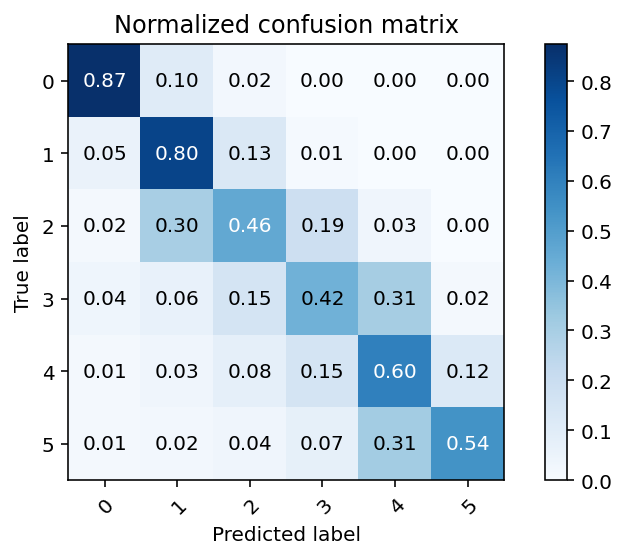

In [33]:
_ = plot_confusion_matrix(val_df.isup_grade, val_df.isup_pred, normalize=True)

In [34]:
logging.info(f"Models: {model_fnames}")

Models: ['22-06-2020-21-27_50_loss.pth', '21-06-2020-17-05_28_loss.pth', '21-06-2020-17-05_35_qwk.pth']


In [35]:
pred_kappa = cohen_kappa_score(val_df.isup_grade, val_df.isup_pred, weights="quadratic")

In [36]:
logging.info(f"Overall kapa: {pred_kappa}")

Overall kapa: 0.8833120288647276


In [37]:
karol_df = val_df[val_df.data_provider == "karolinska"].copy()
kapa_karol = cohen_kappa_score(karol_df.isup_grade, karol_df.isup_pred, weights="quadratic")
logging.info(f"Karolinska kapa: {kapa_karol}")

Karolinska kapa: 0.8880347736445314


In [38]:
radboud_df = val_df[val_df.data_provider == "radboud"].copy()
kapa_radboud = cohen_kappa_score(radboud_df.isup_grade, radboud_df.isup_pred, weights="quadratic")
logging.info(f"Radboud kapa: {kapa_radboud}")

Radboud kapa: 0.8523125500470996


#### Optimize Rounding

In [39]:
rnd_sample_ids = val_df.sample(frac=0.5).index

In [40]:
val_df["eval"] = 0
val_df.loc[rnd_sample_ids, "eval"] = 1

In [41]:
dev_preds = val_df.loc[val_df["eval"] == 0, "isup_raw_pred"].values
dev_targs = val_df.loc[val_df["eval"] == 0, "isup_grade"].values
eval_preds = val_df.loc[val_df["eval"] == 1, "isup_raw_pred"].values
eval_targs = val_df.loc[val_df["eval"] == 1, "isup_grade"].values

In [42]:
opt_r = OptimizedRounder()
opt_r.fit(dev_preds, dev_targs)

In [43]:
coefficients = opt_r.coefficients()
logging.info(f"Optimized coefs: {coefficients}")

Optimized coefs: [0.56038102 1.44775224 2.51632209 3.3955281  4.23538726]


In [44]:
eval_preds_round = opt_r.predict(val_df.isup_raw_pred, coefficients)

In [45]:
round_opt_kapa = cohen_kappa_score(val_df.isup_grade, eval_preds_round, weights="quadratic")

In [46]:
logging.info(f"Optimized round kapa: {round_opt_kapa}")

Optimized round kapa: 0.8876159481016987


#### Check results with Hard Class Permutation

In [43]:
hard_cls_values = val_df.loc[val_df.isup_pred.isin([2,3,4]), "isup_pred"].copy().values

In [44]:
hard_cls_values[:5]

array([4, 3, 4, 2, 3])

In [45]:
np.random.shuffle(hard_cls_values)

In [46]:
hard_cls_values[:5]

array([3, 4, 3, 4, 2])

In [47]:
val_df.loc[val_df.isup_pred.isin([2,3,4]), "isup_pred"] = hard_cls_values

Normalized confusion matrix
[[0.94382022 0.03792135 0.00702247 0.00421348 0.00280899 0.00421348]
 [0.0830721  0.79937304 0.03605016 0.04702194 0.03291536 0.0015674 ]
 [0.04126984 0.27936508 0.25396825 0.22222222 0.18412698 0.01904762]
 [0.09310345 0.05862069 0.26896552 0.23793103 0.24482759 0.09655172]
 [0.0652921  0.03780069 0.26460481 0.25429553 0.2371134  0.14089347]
 [0.05818182 0.01454545 0.11636364 0.10545455 0.14909091 0.55636364]]


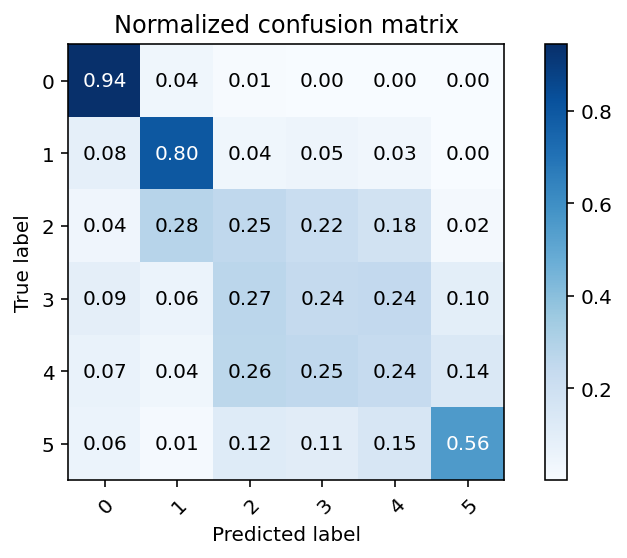

In [48]:
_ = plot_confusion_matrix(val_df.isup_grade, val_df.isup_pred, normalize=True)

In [49]:
permute_kapa = cohen_kappa_score(val_df.isup_grade, val_df.isup_pred, weights="quadratic")
permute_kapa

0.7659439769237075

In [50]:
print(f"Permutation importance: {1 - (permute_kapa/pred_kappa)}")

Permutation importance: 0.07017338008015972


In [34]:
# LB
print(f"LB Permutation importance: {1 - (0.80/0.84)}")

LB Permutation importance: 0.04761904761904756
